In [102]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.stats import iqr
from datetime import date, timedelta

/tmp/ipykernel_126361/134915361.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))


KeyboardInterrupt: 

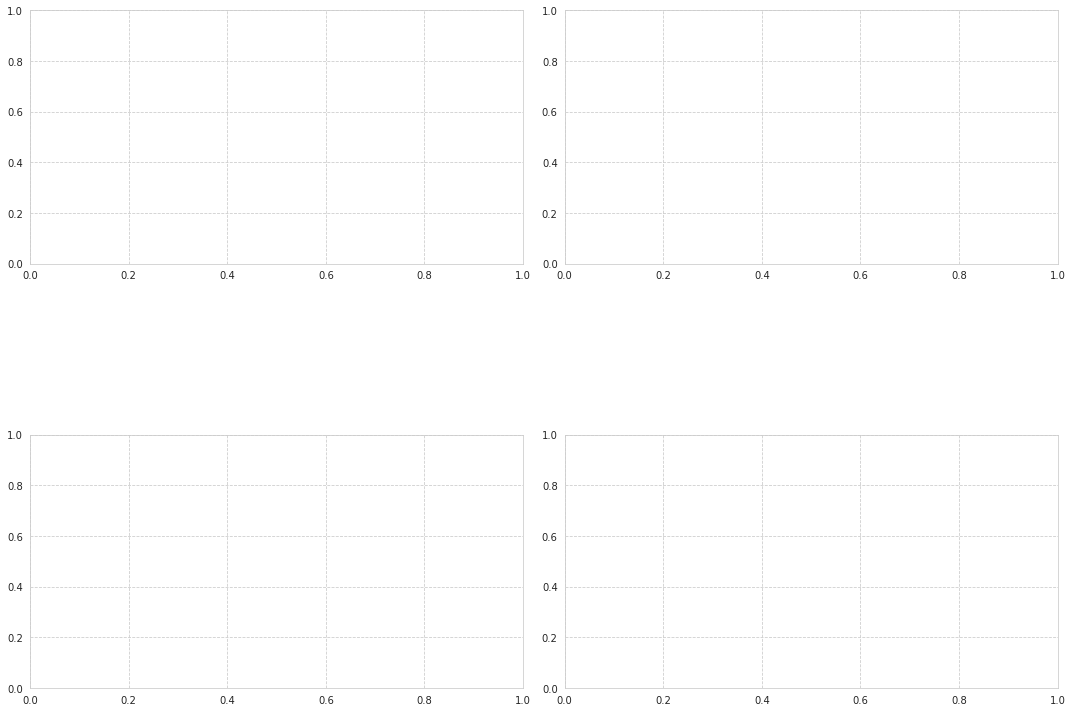

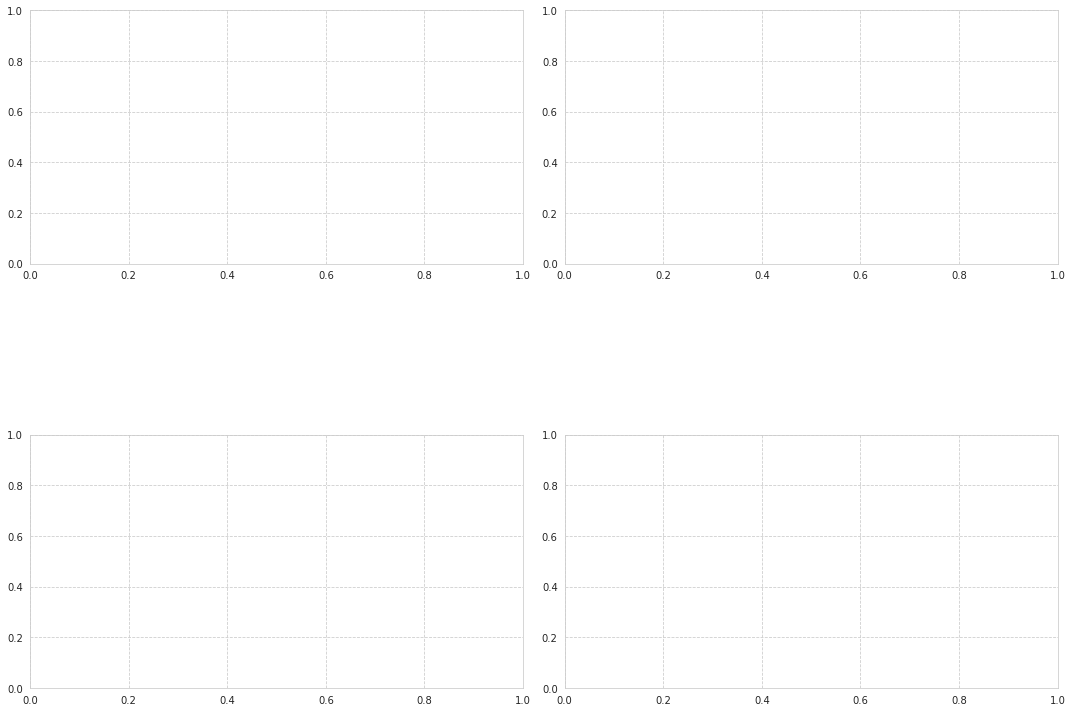

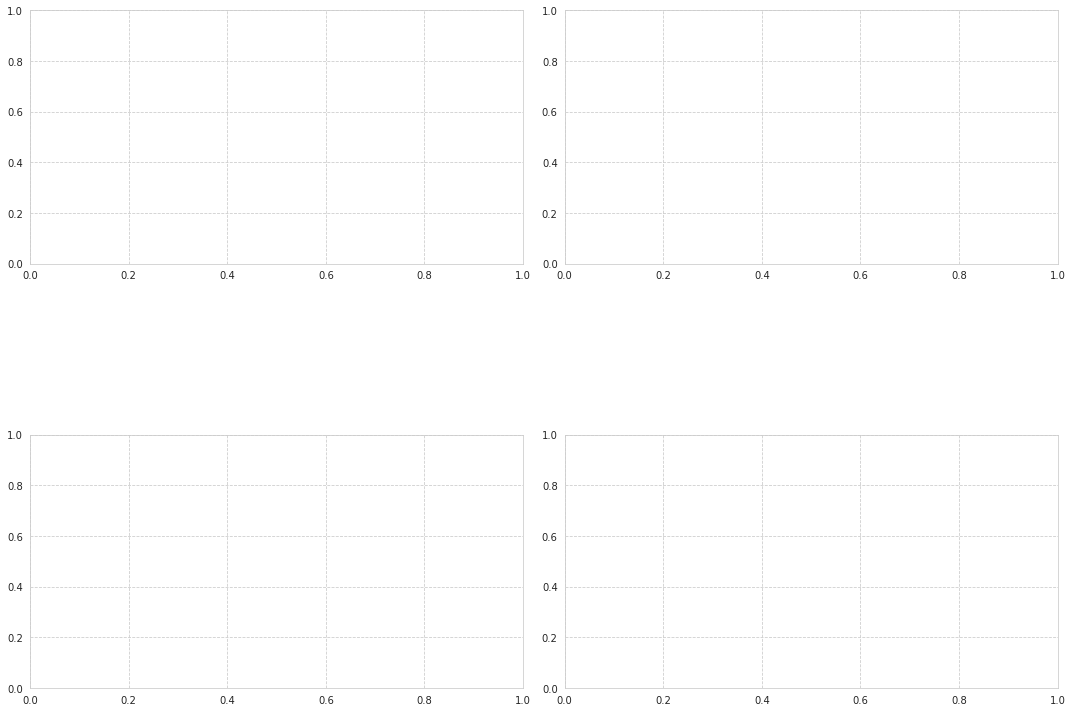

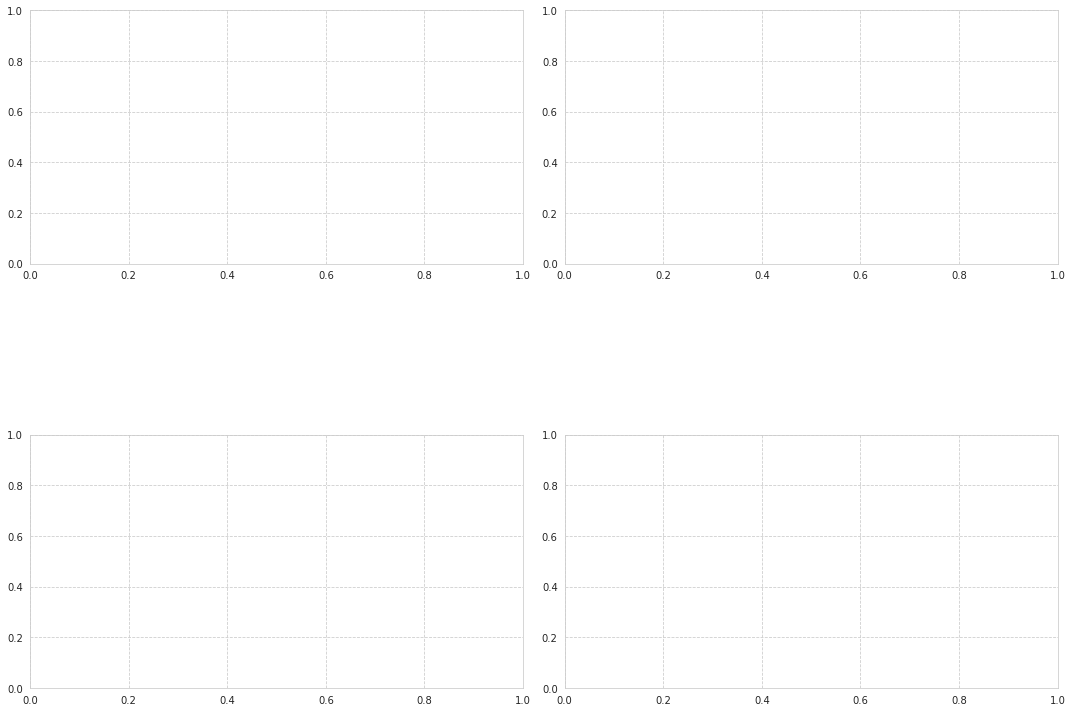

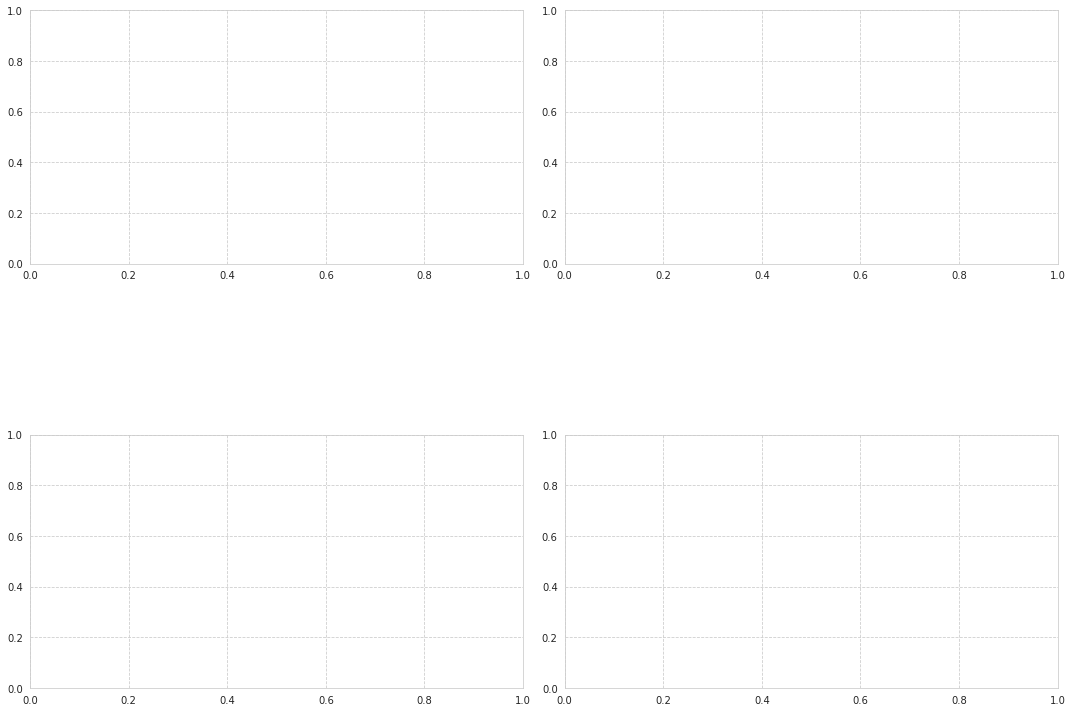

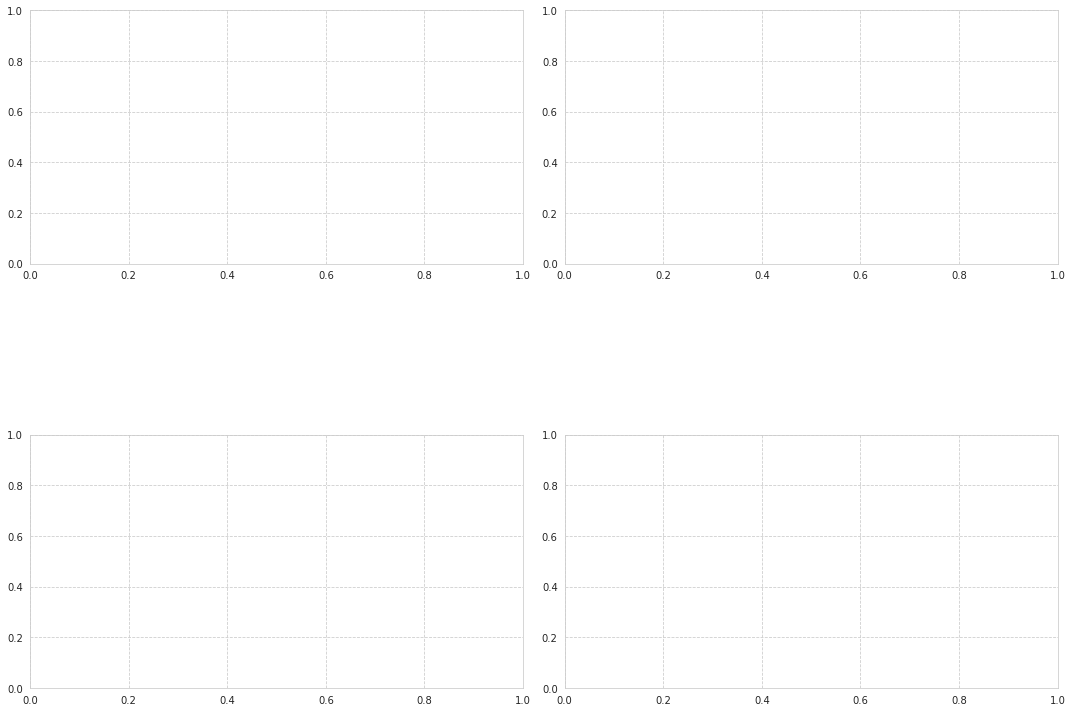

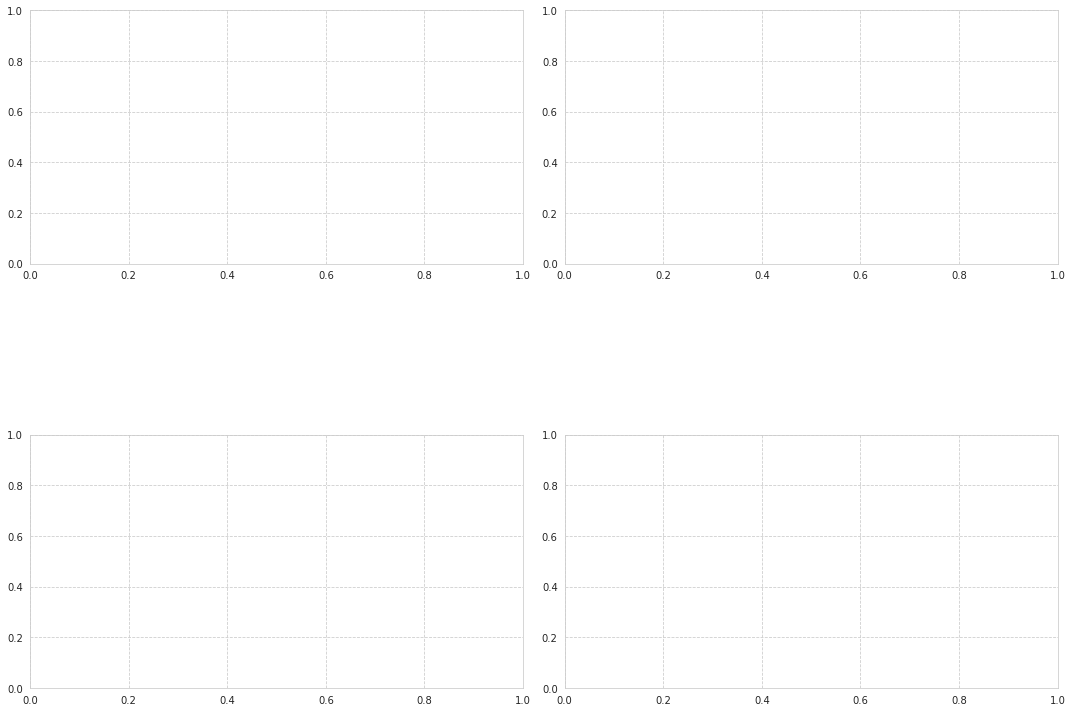

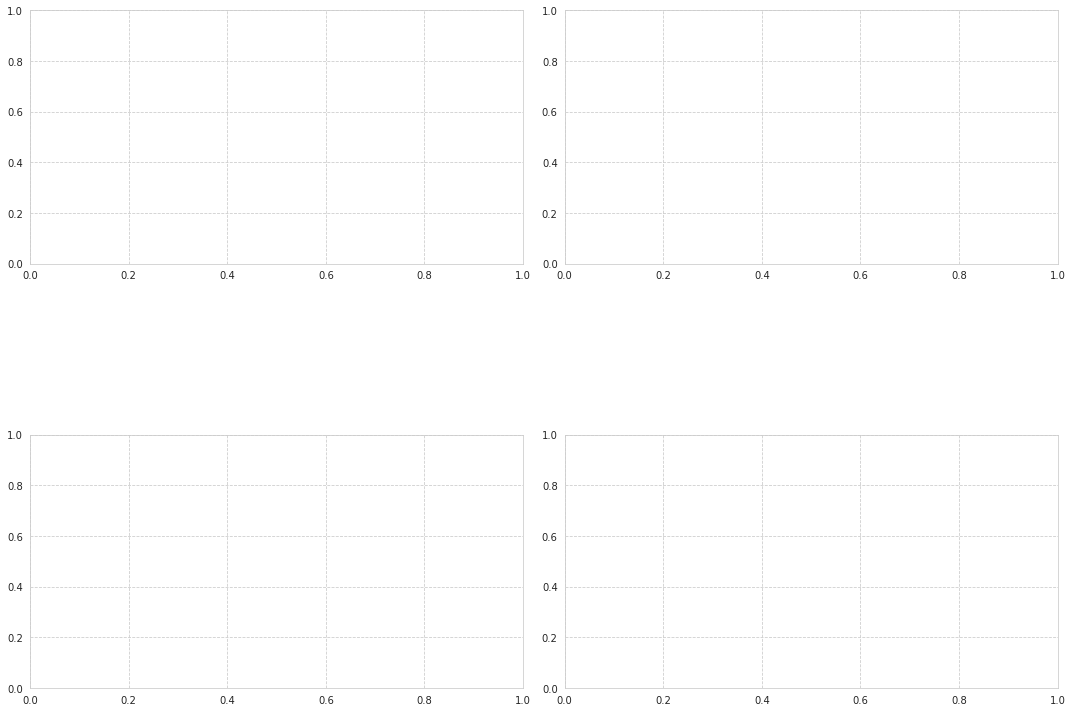

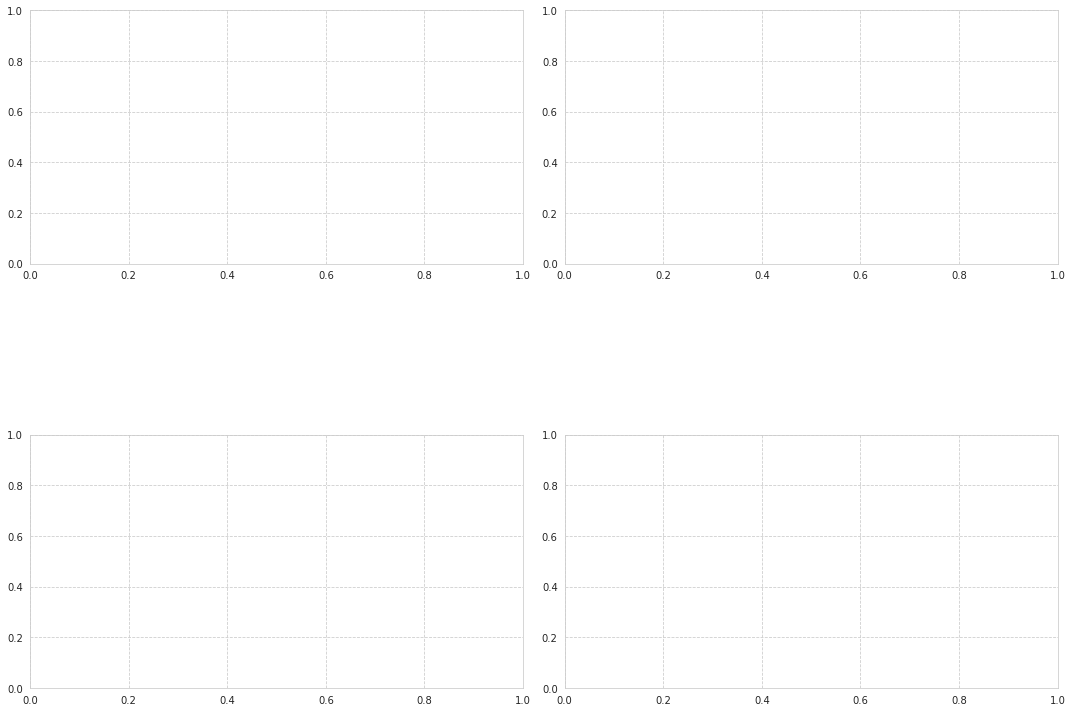

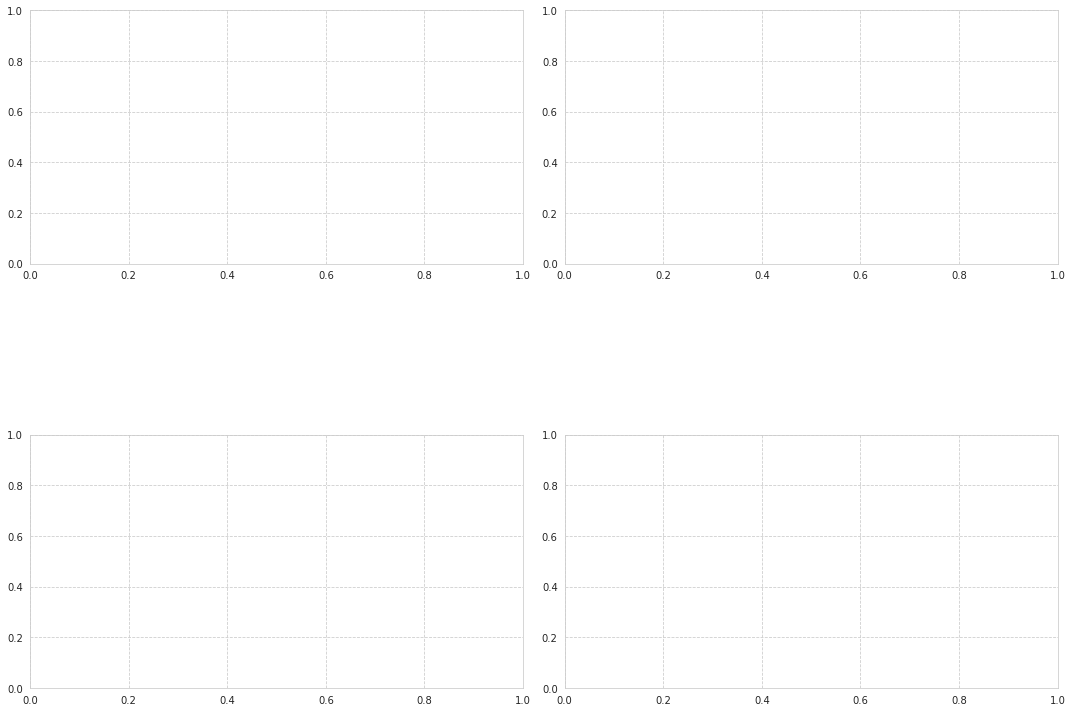

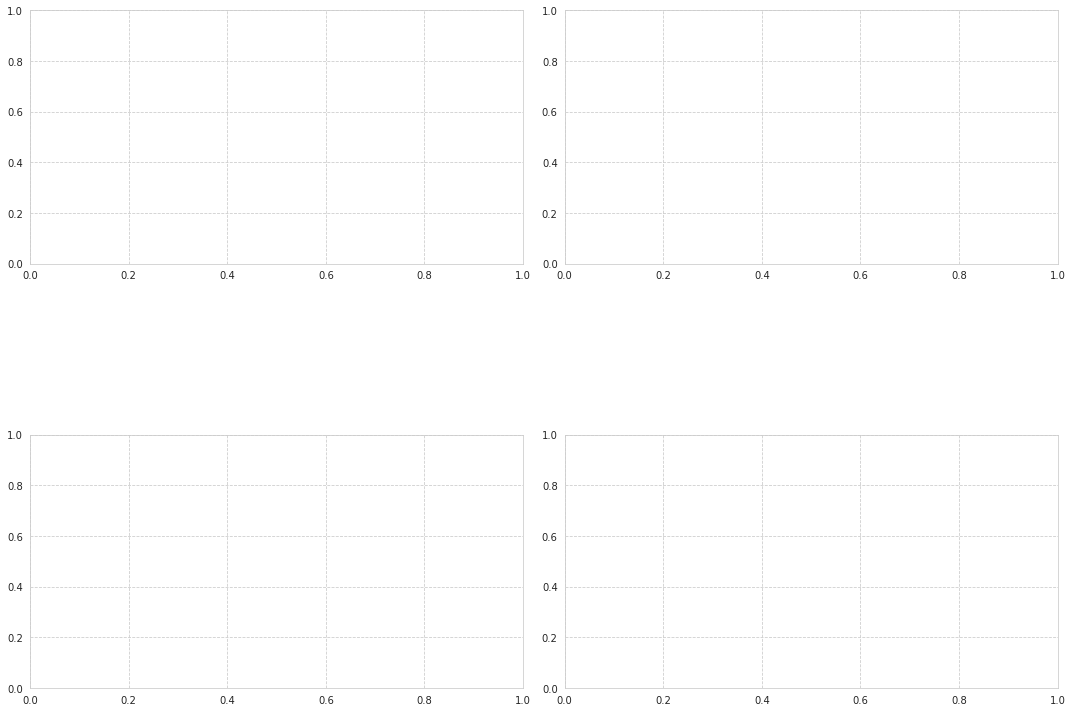

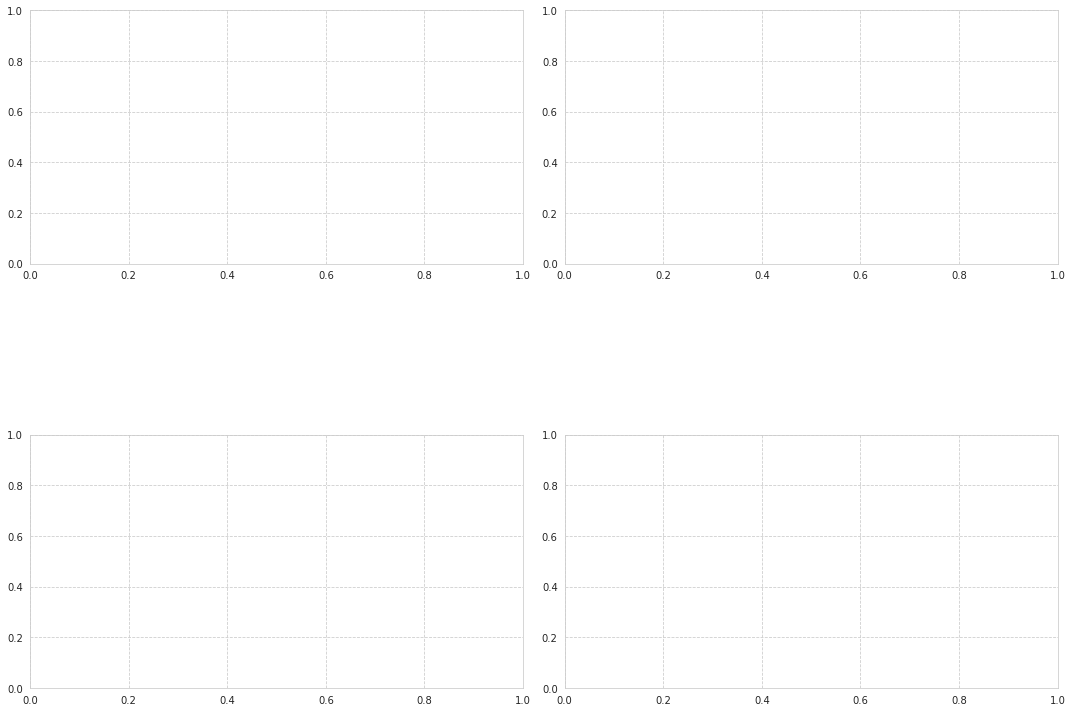

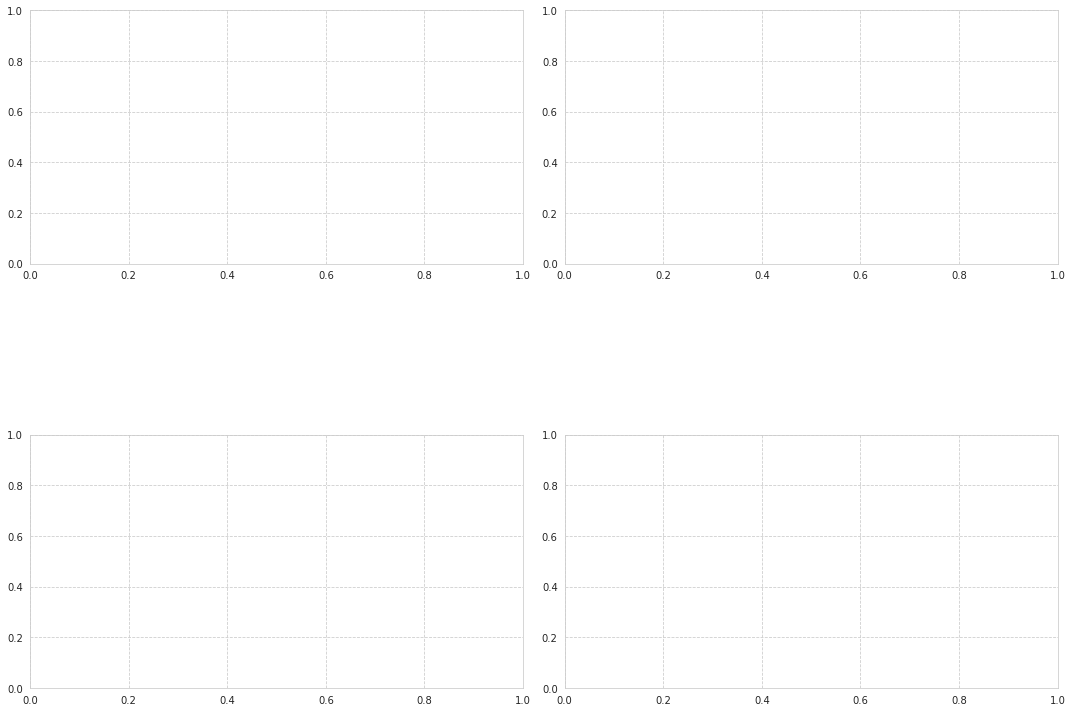

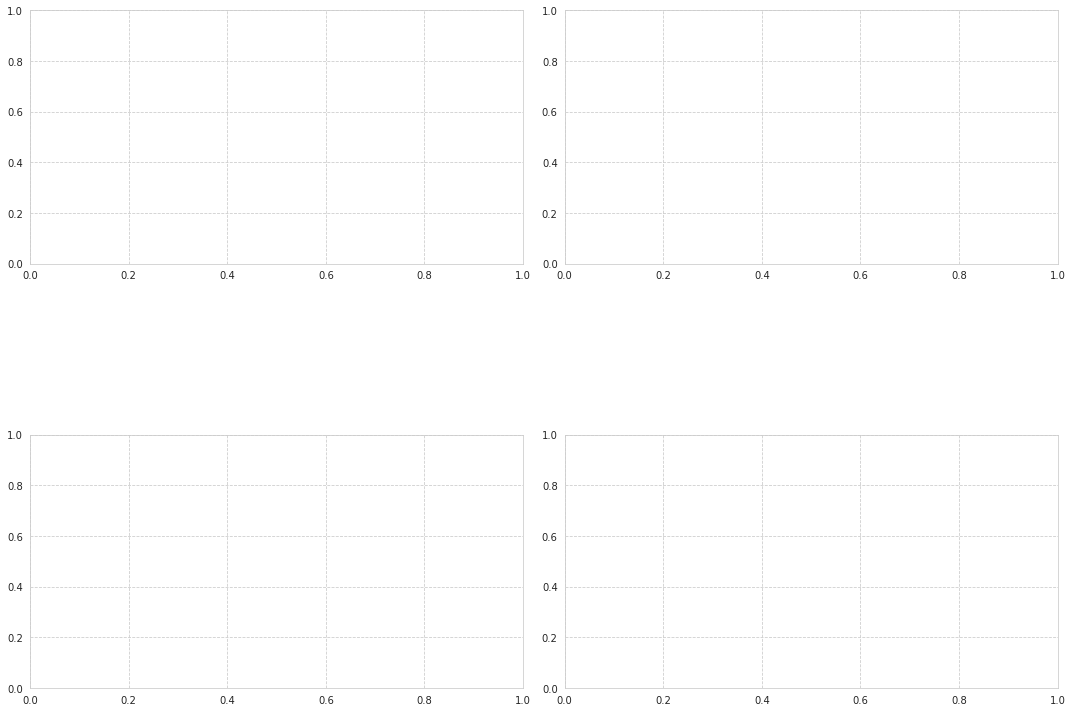

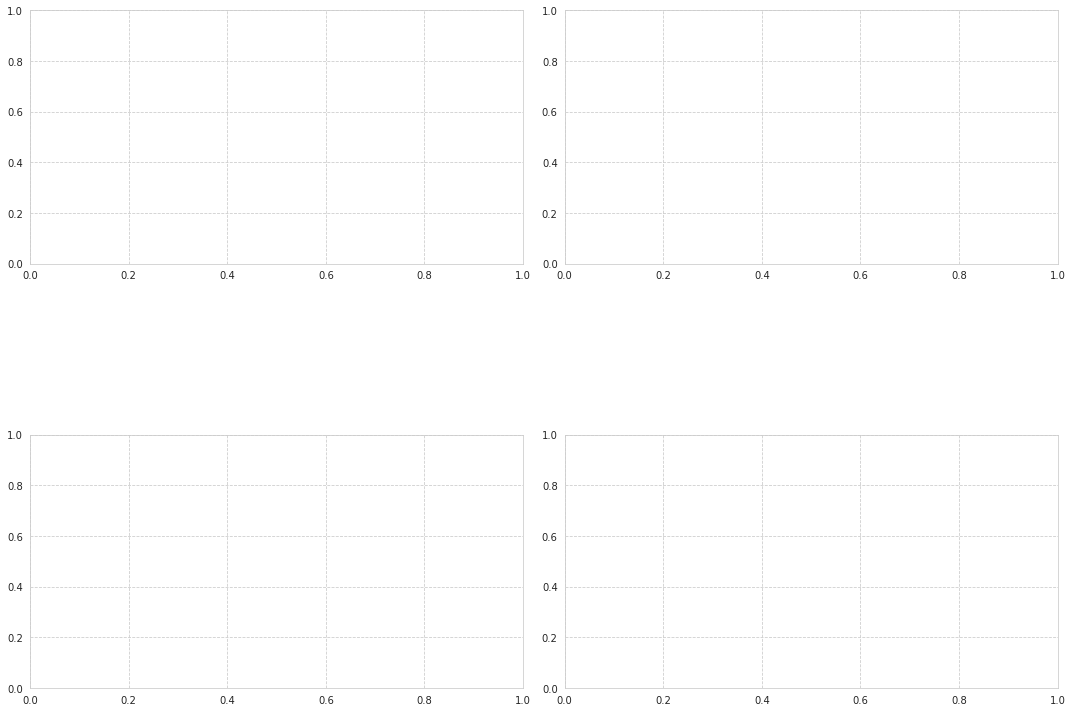

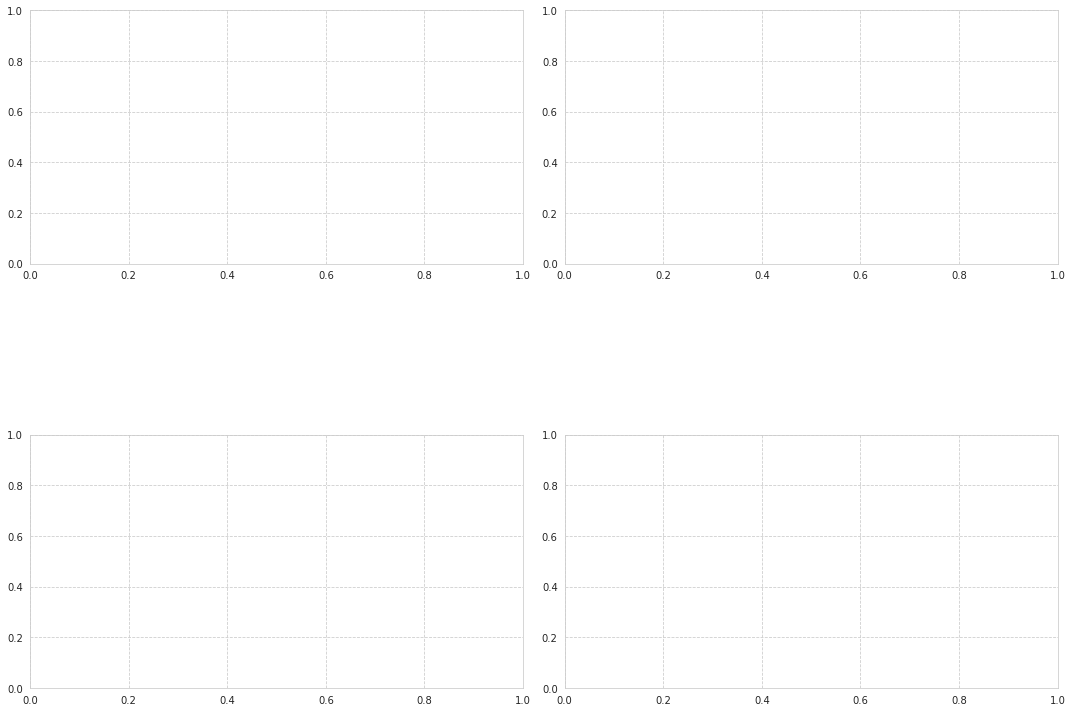

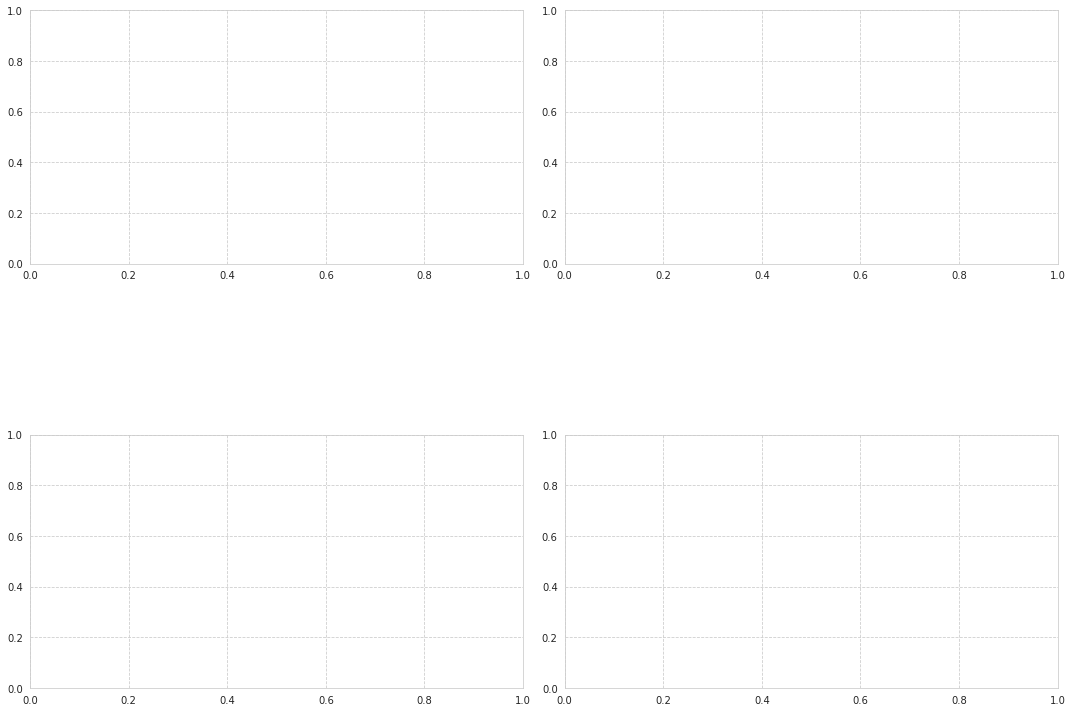

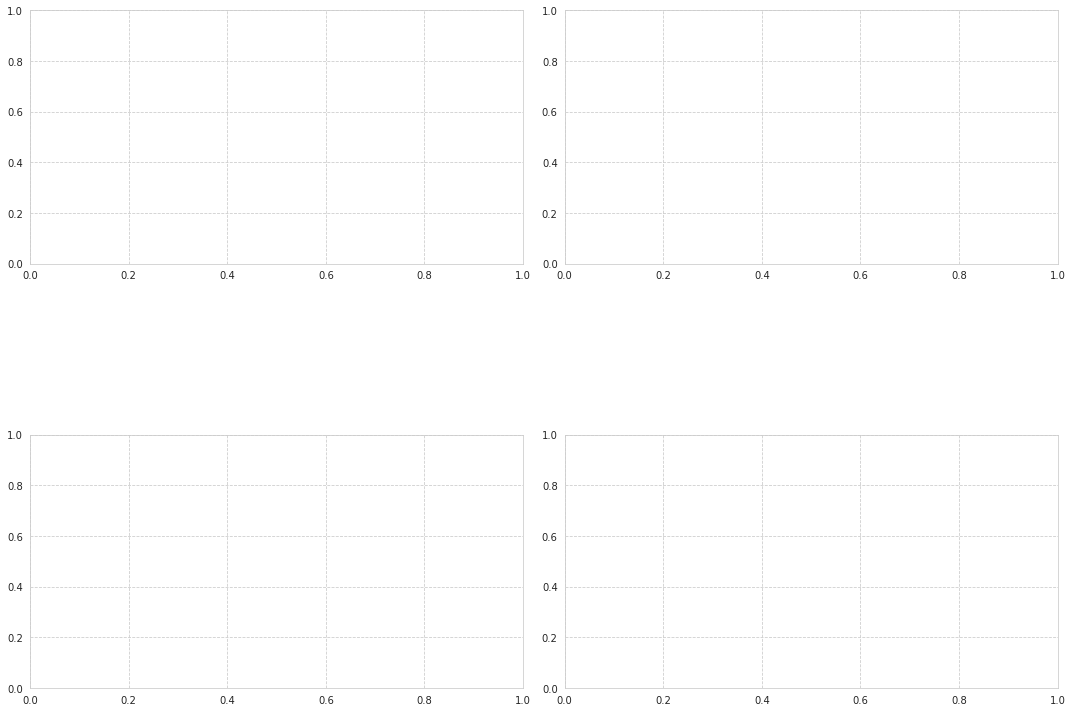

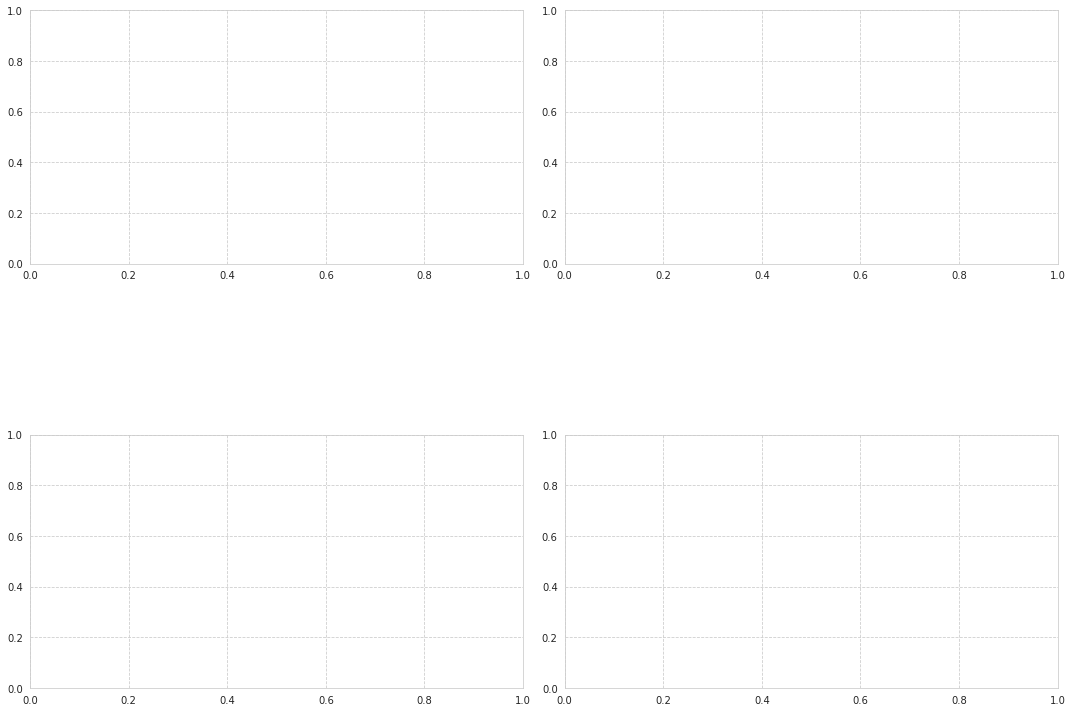

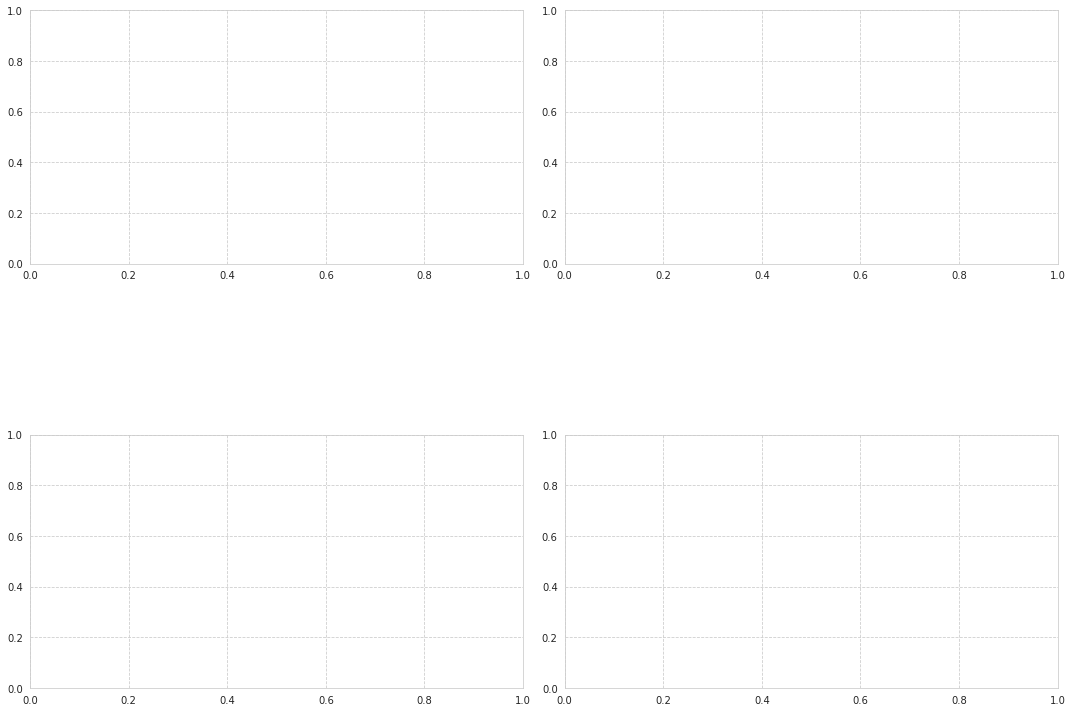

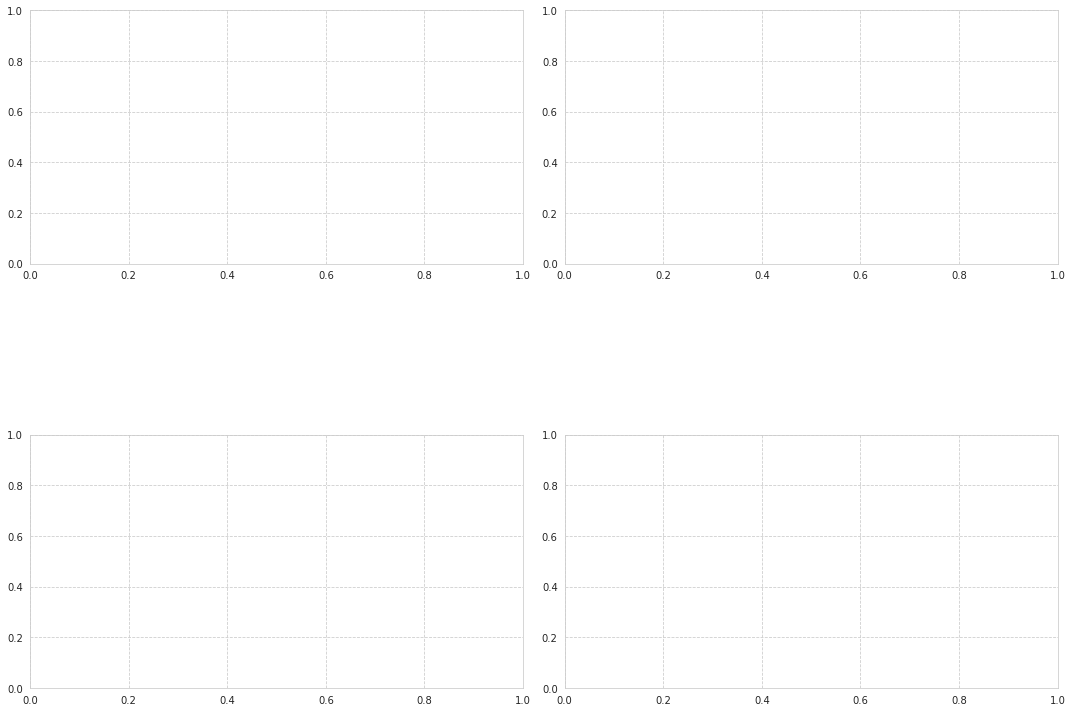

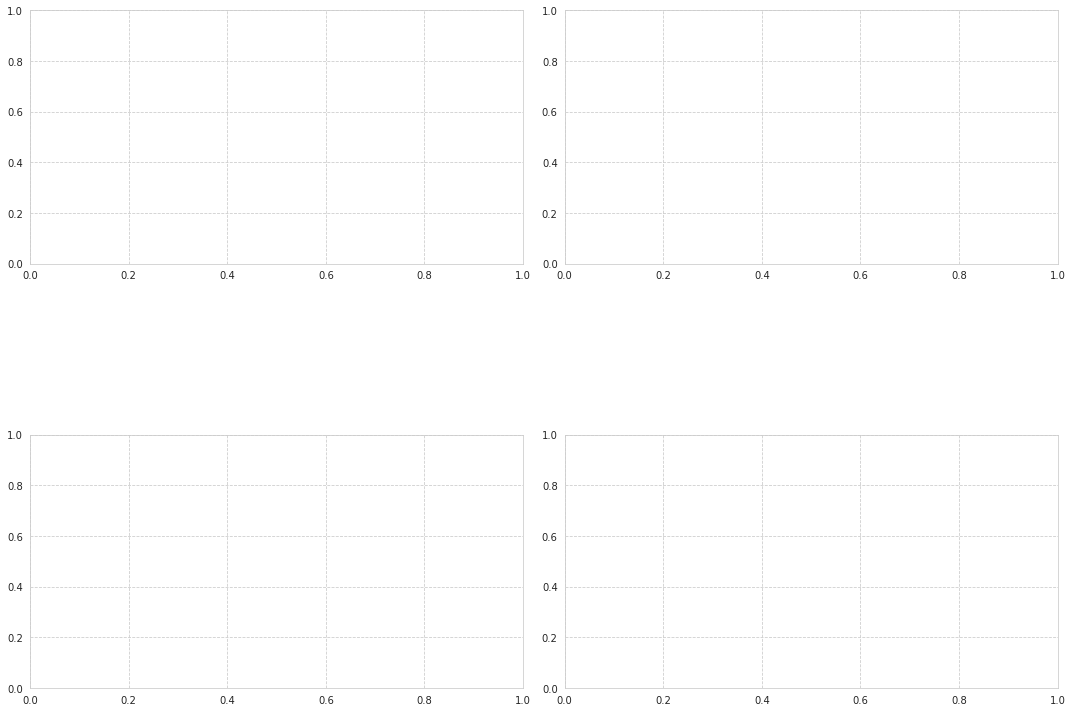

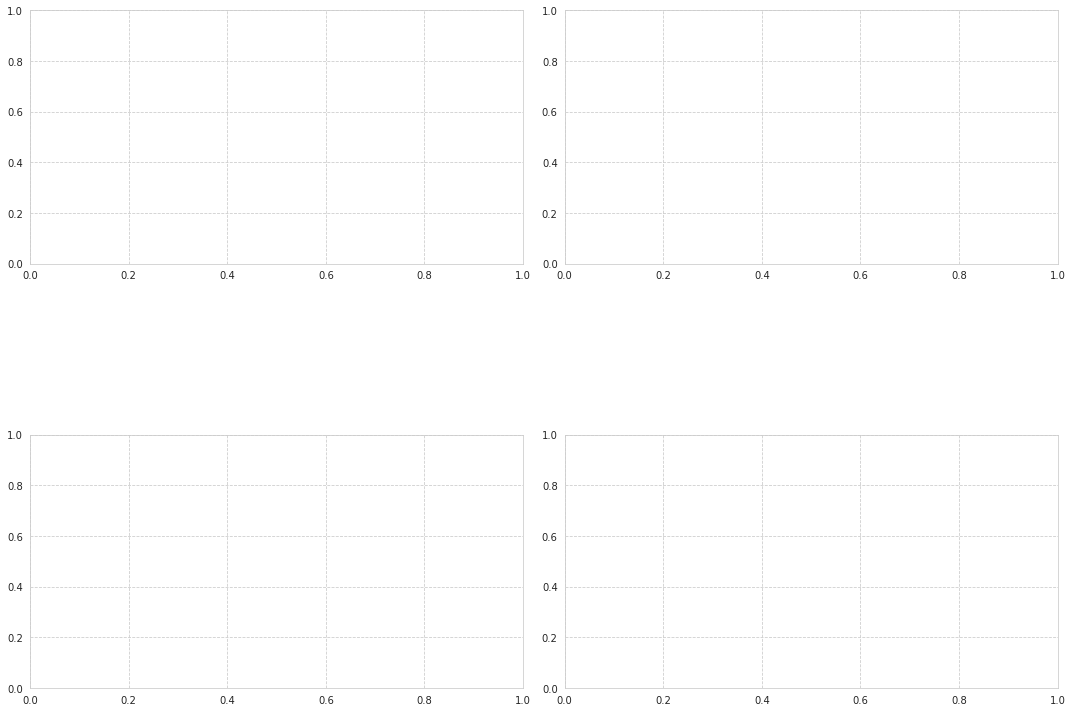

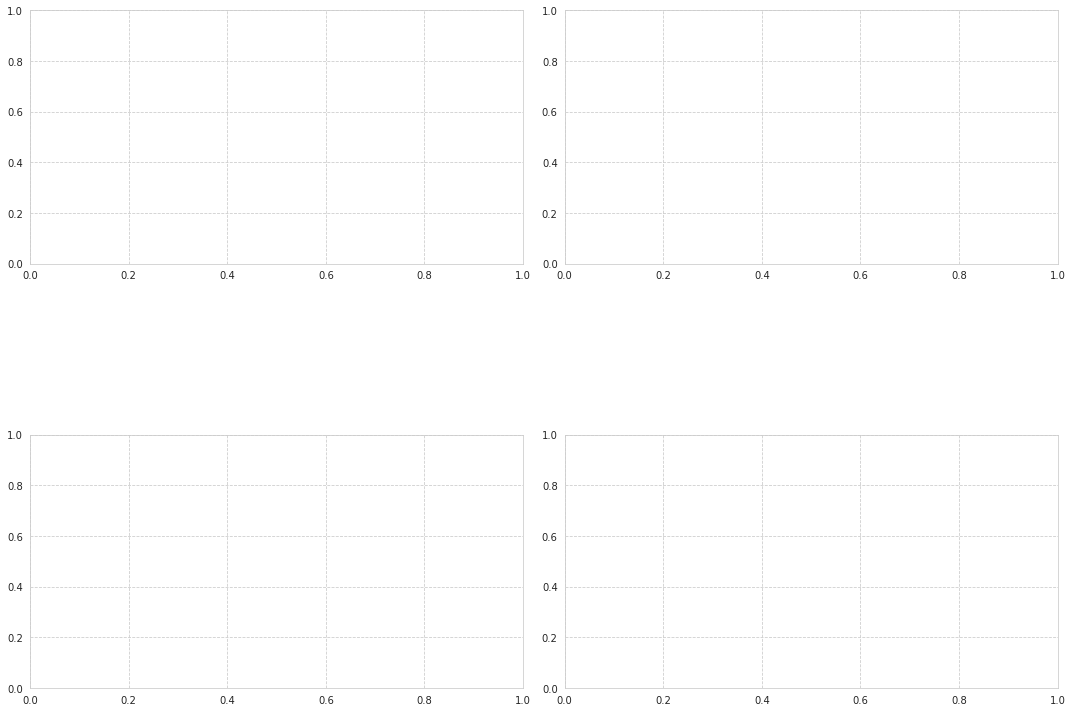

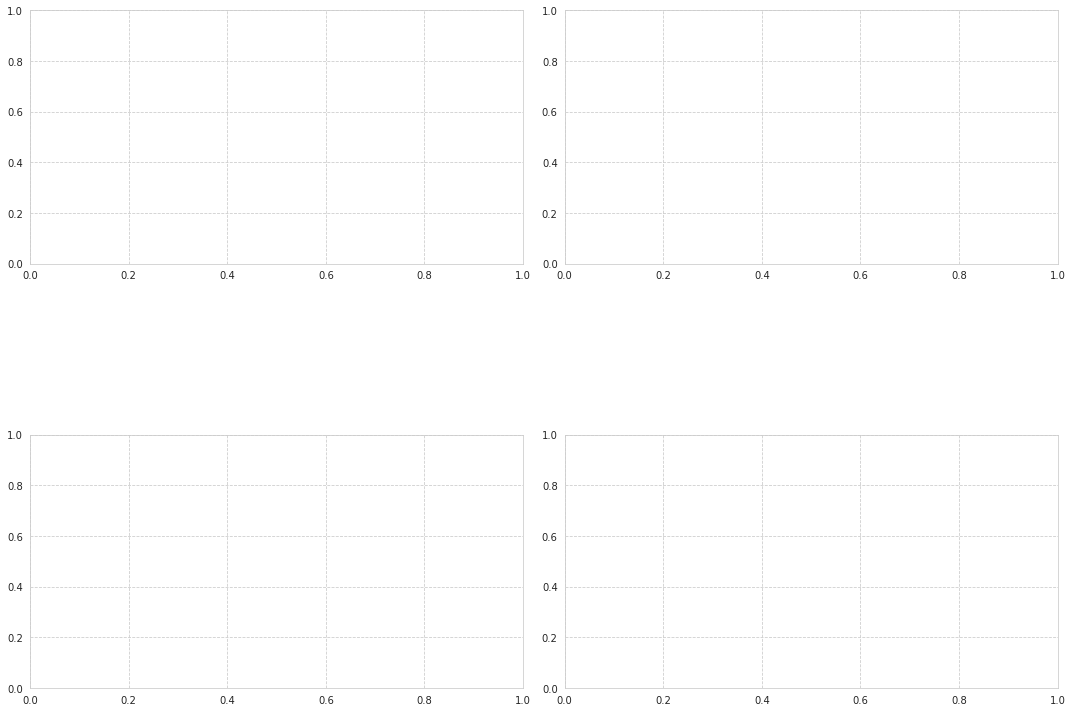

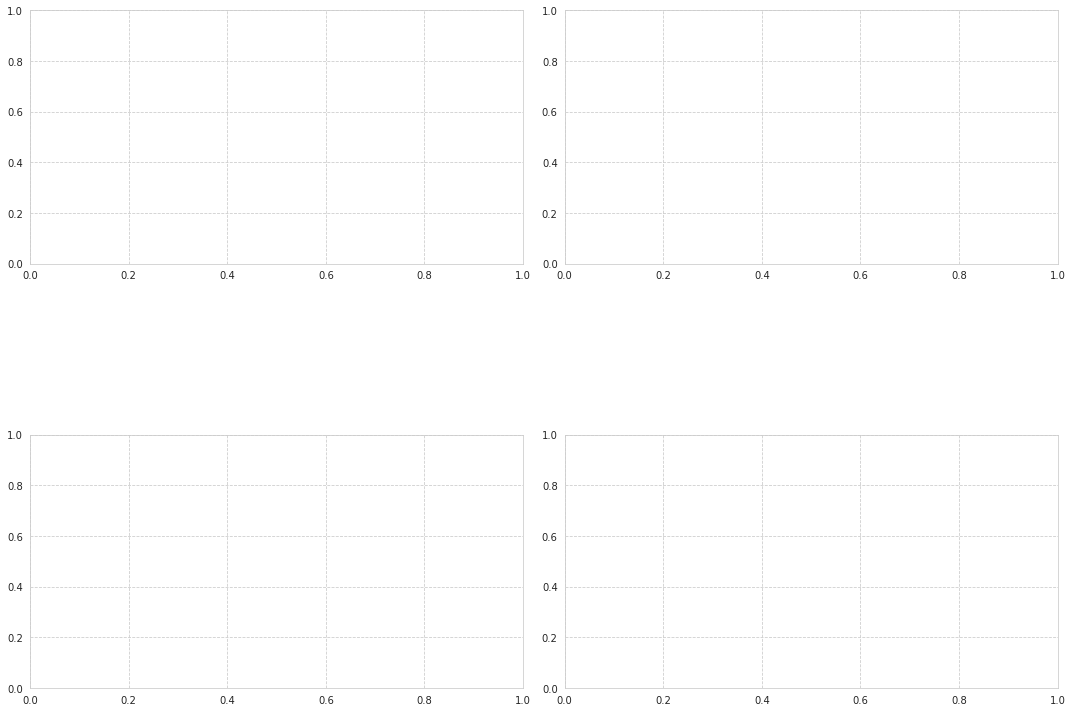

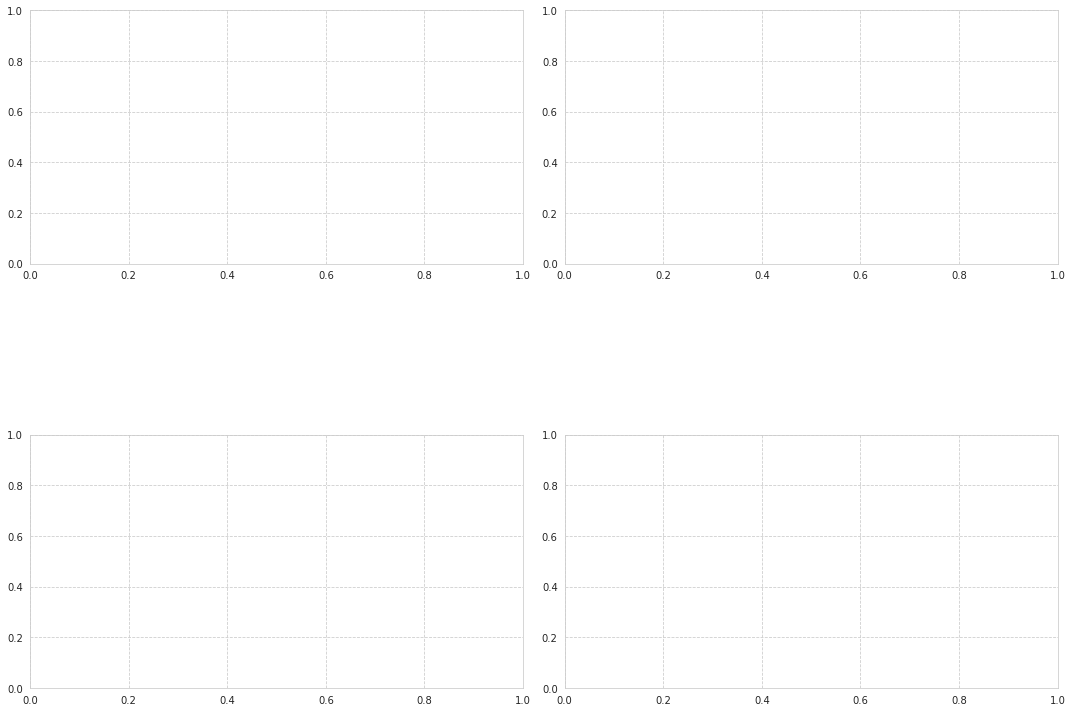

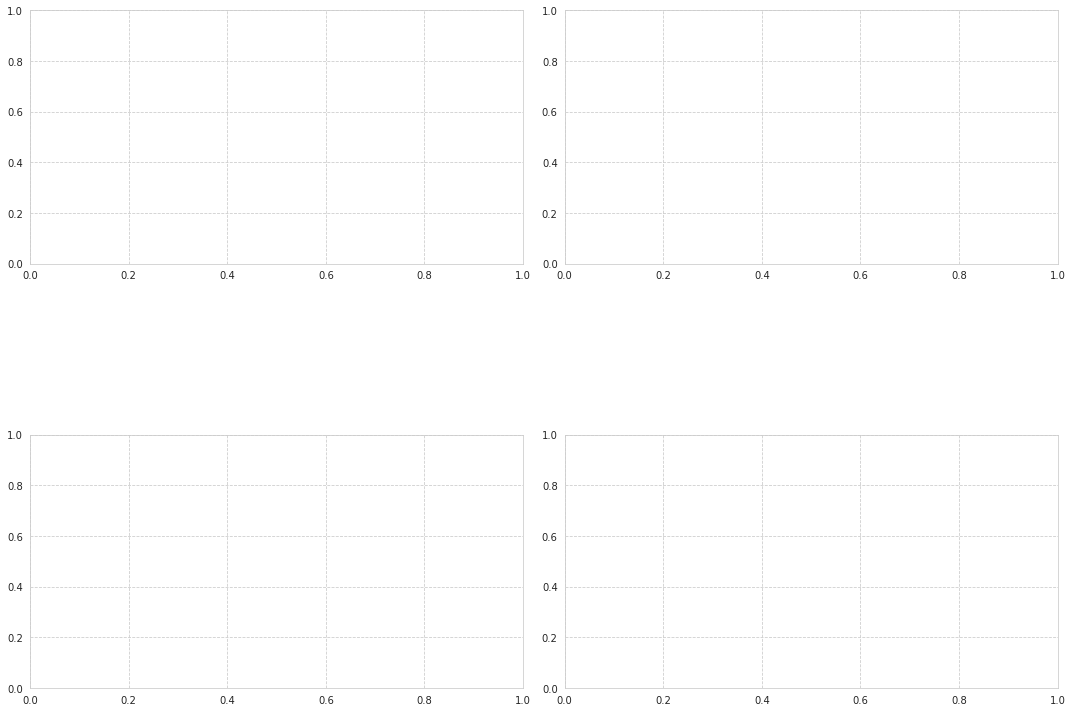

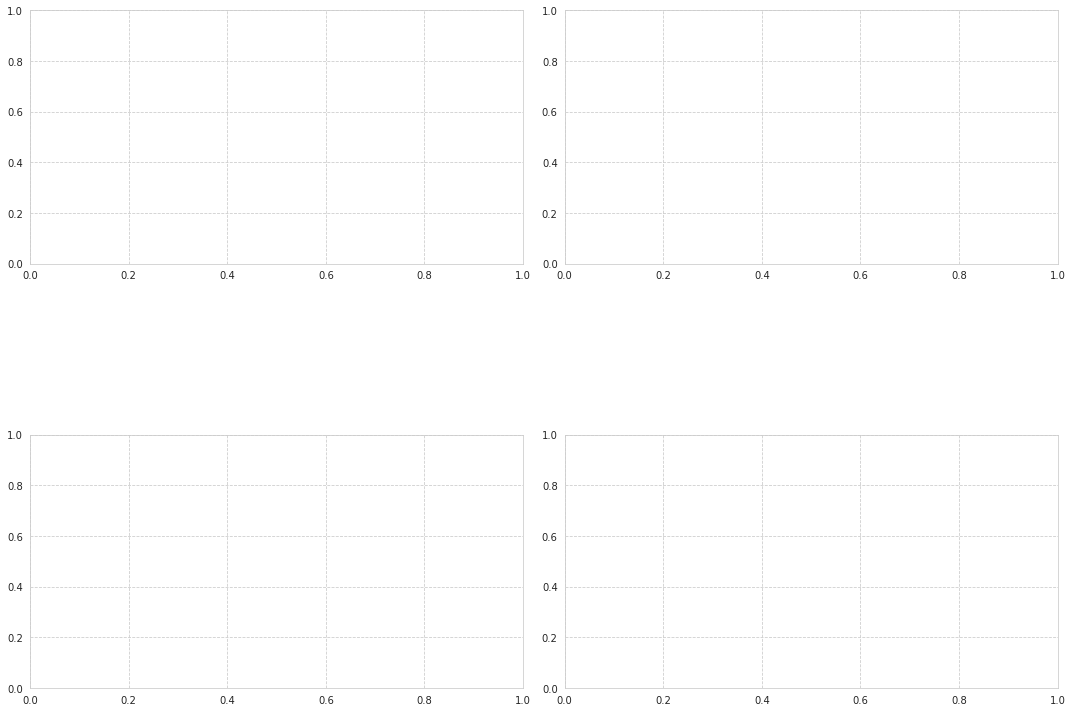

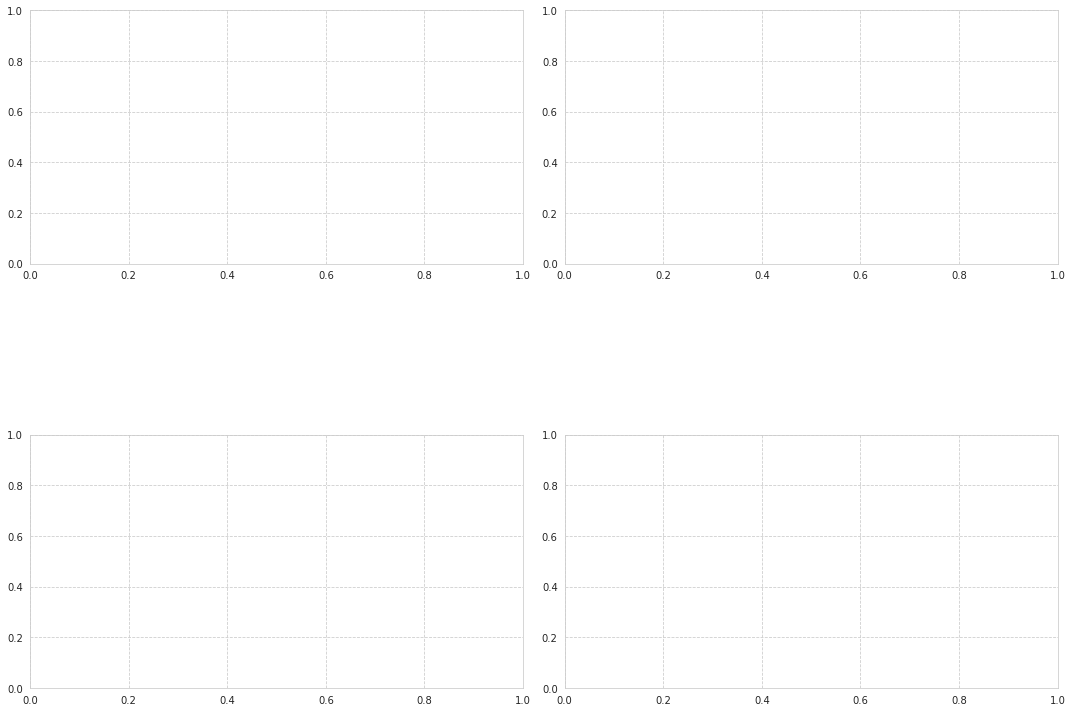

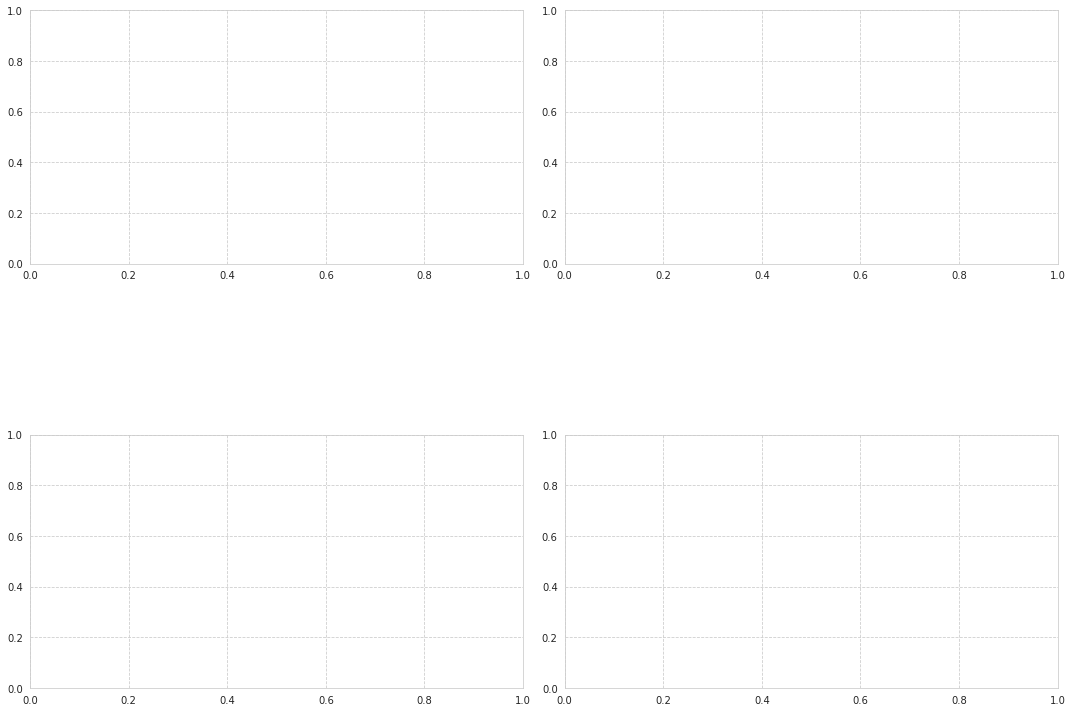

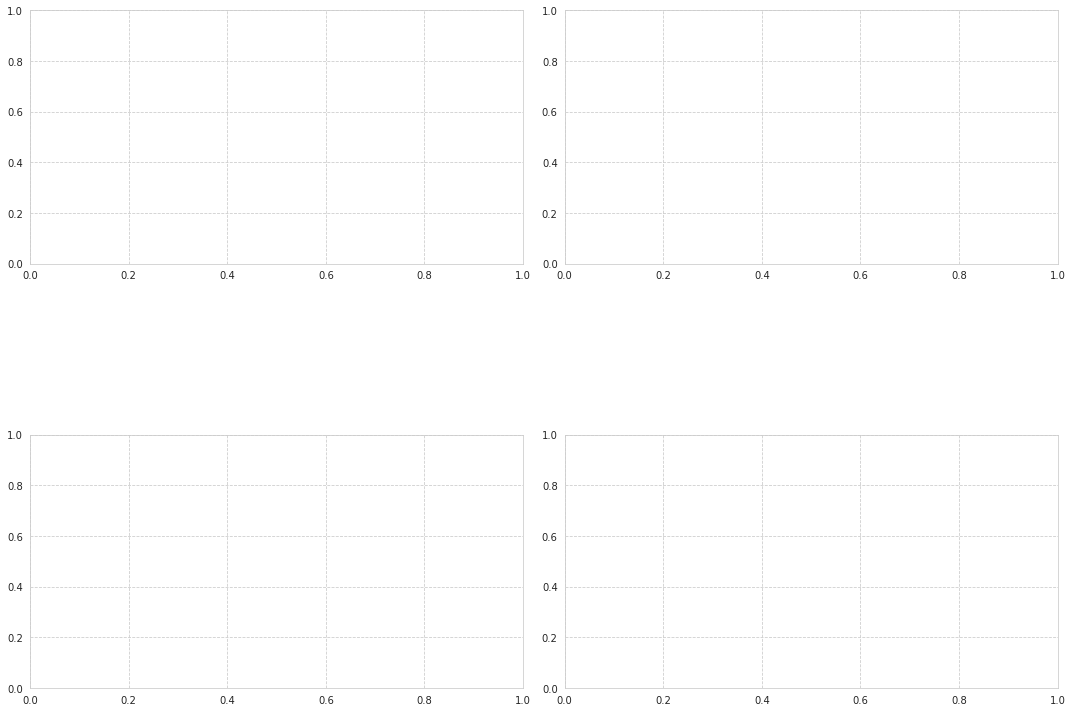

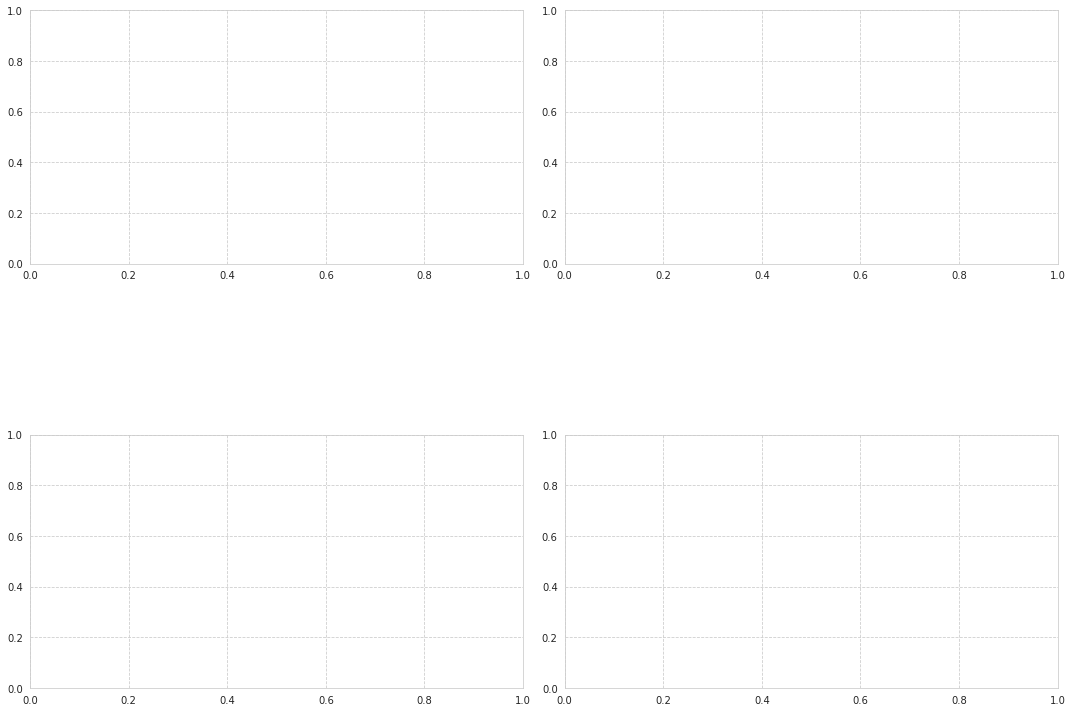

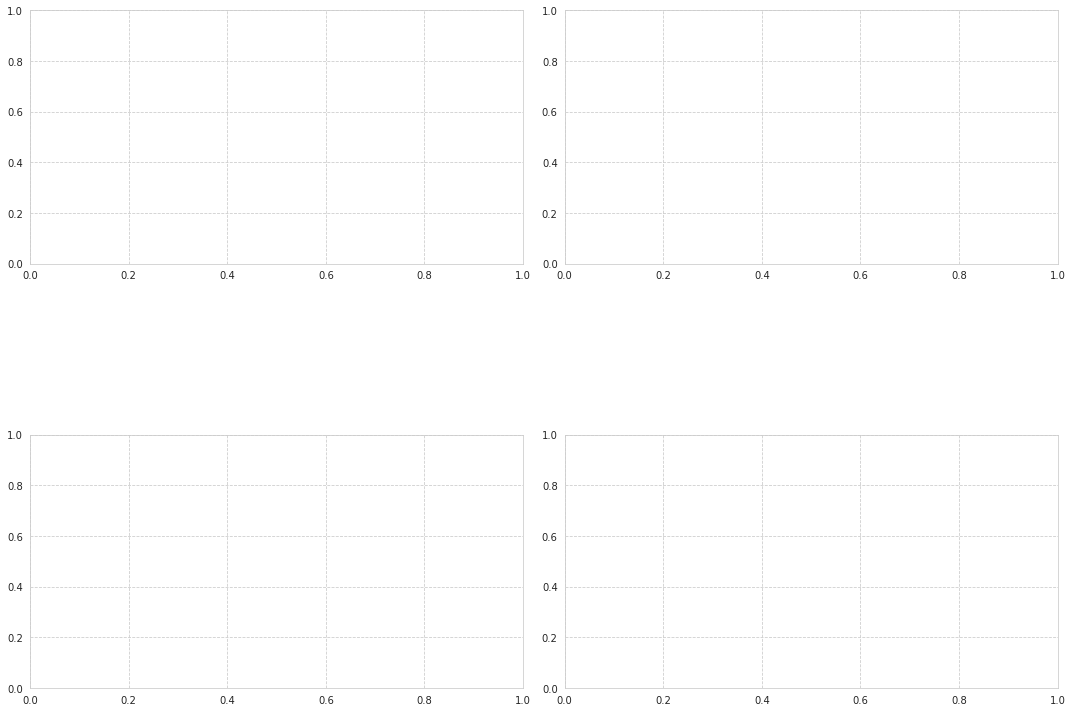

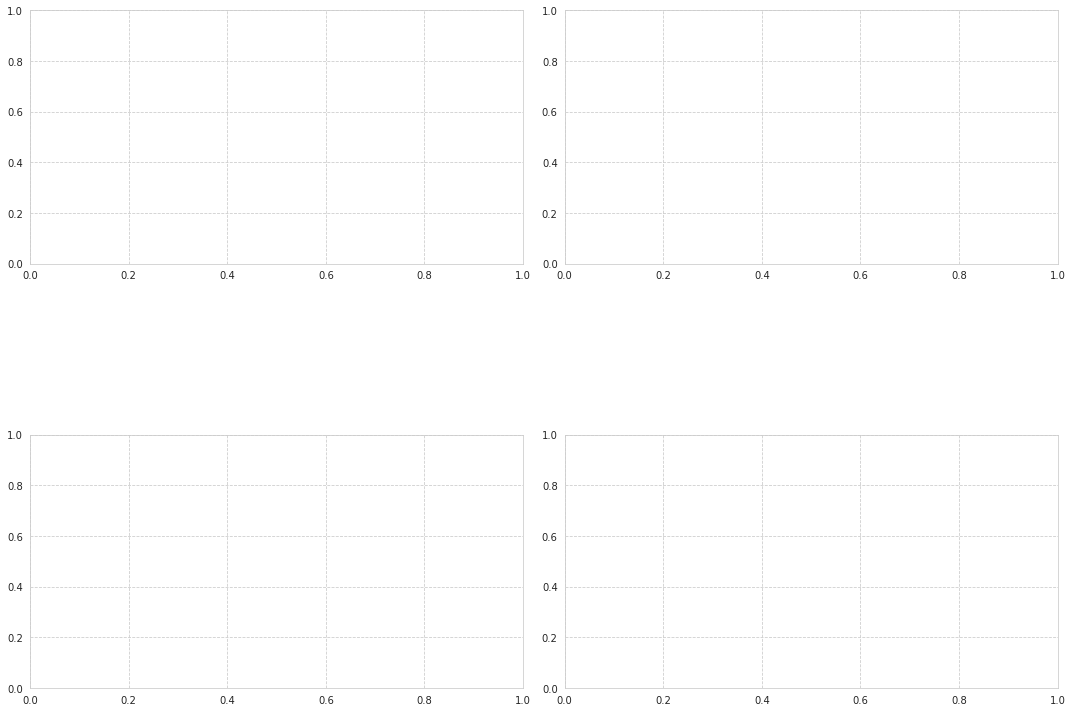

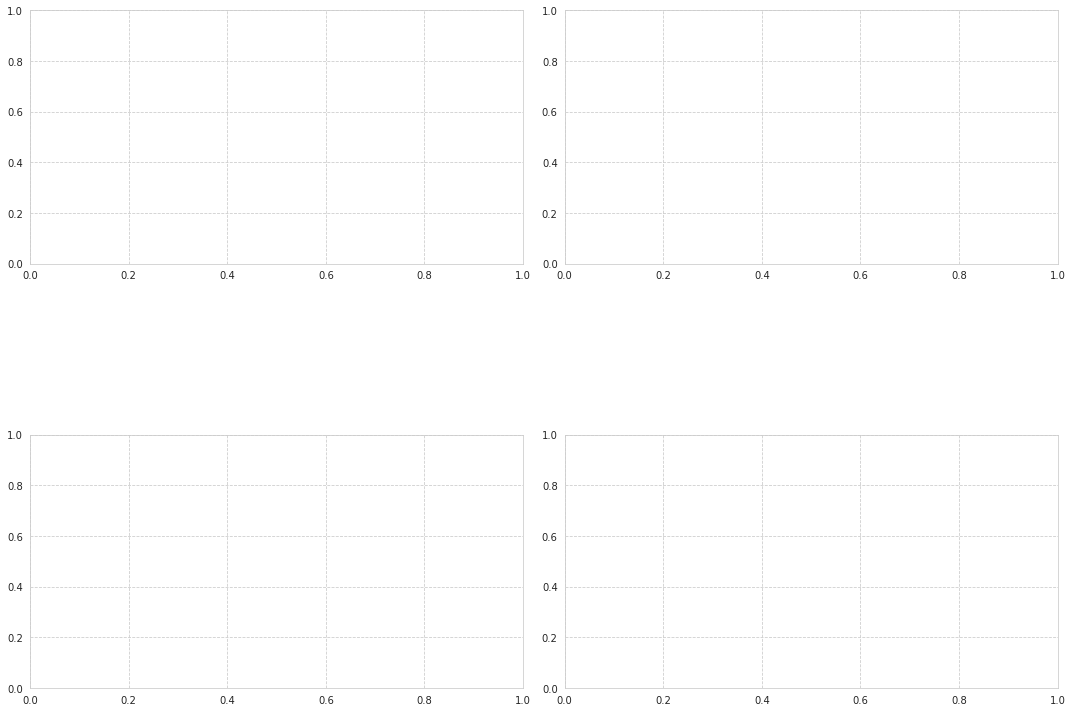

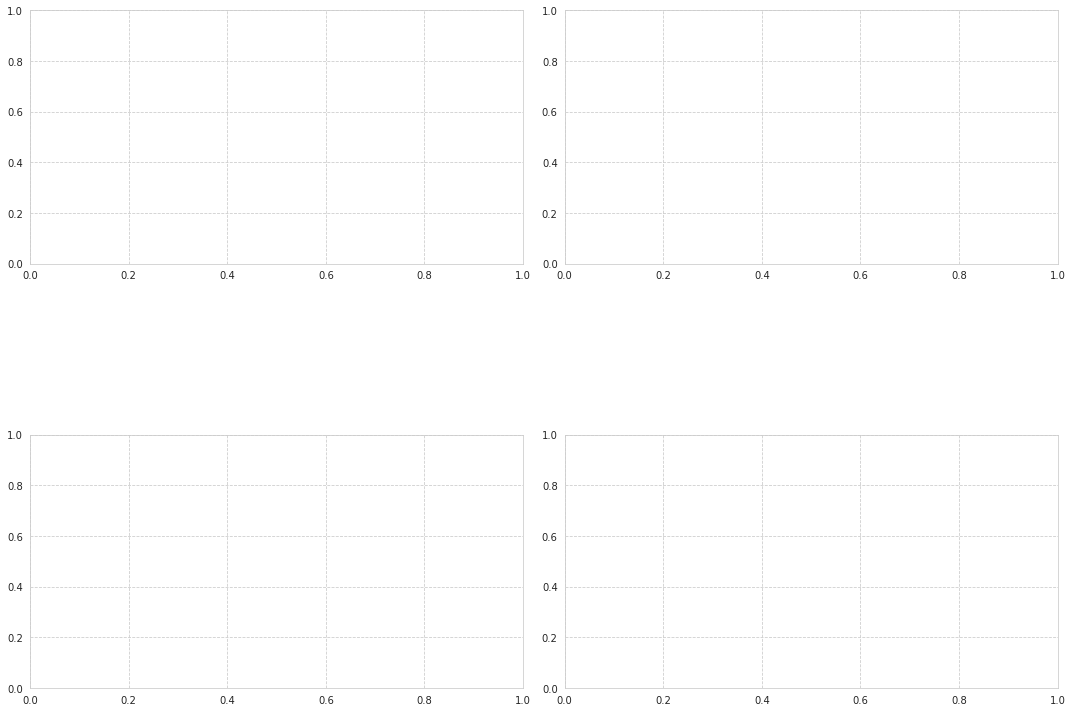

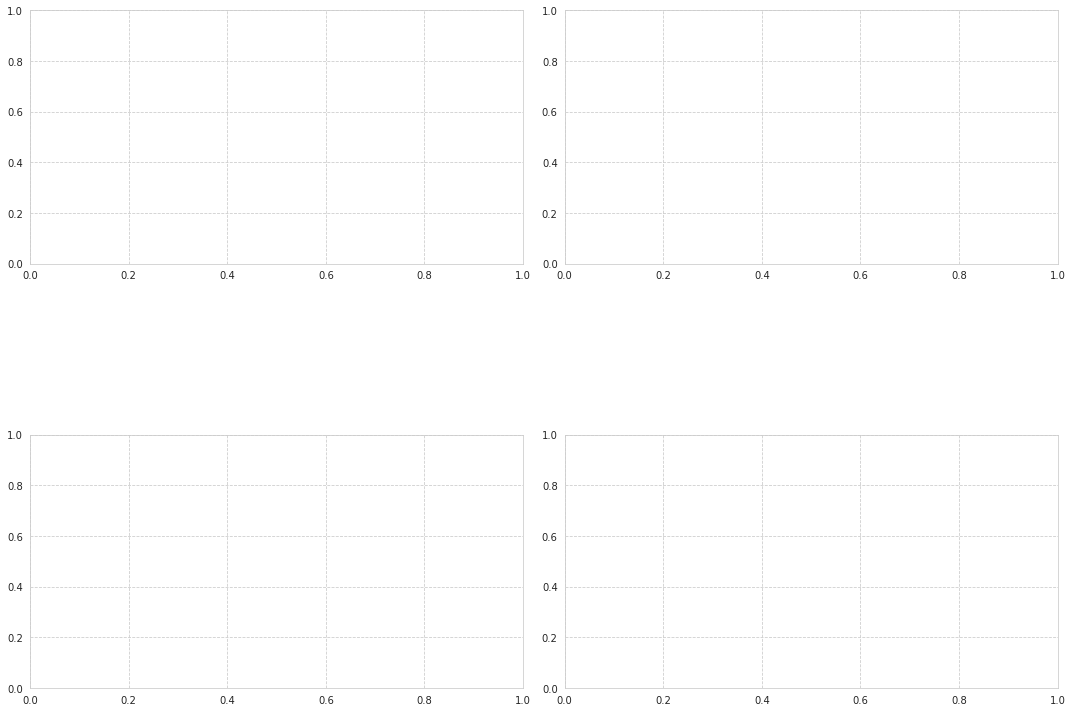

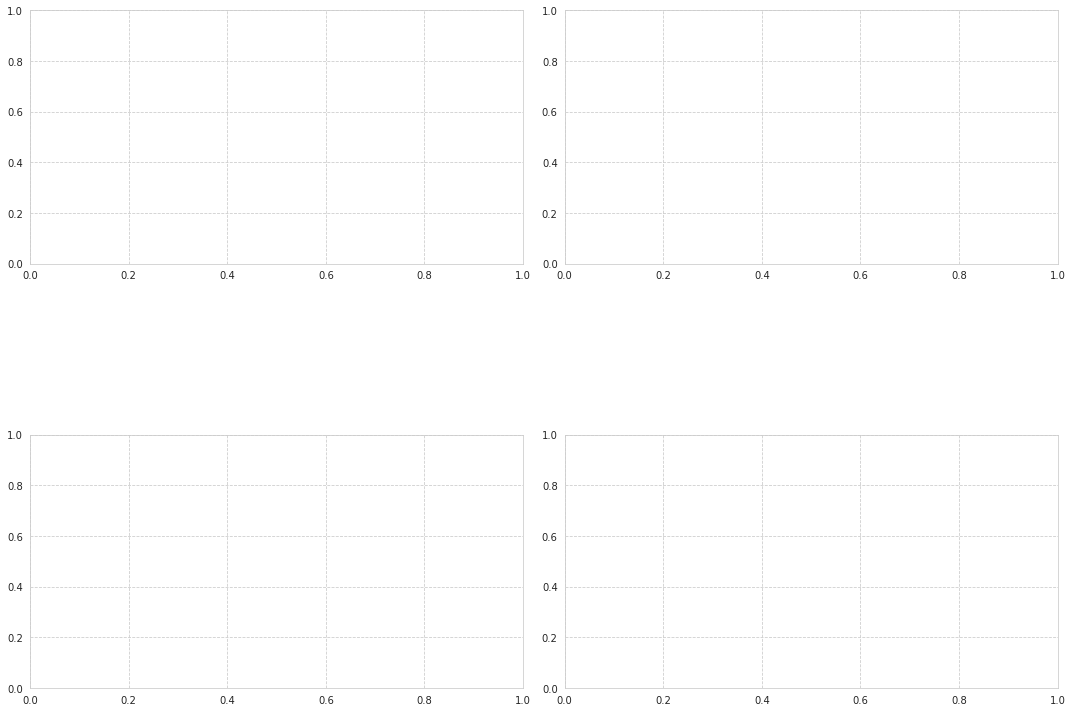

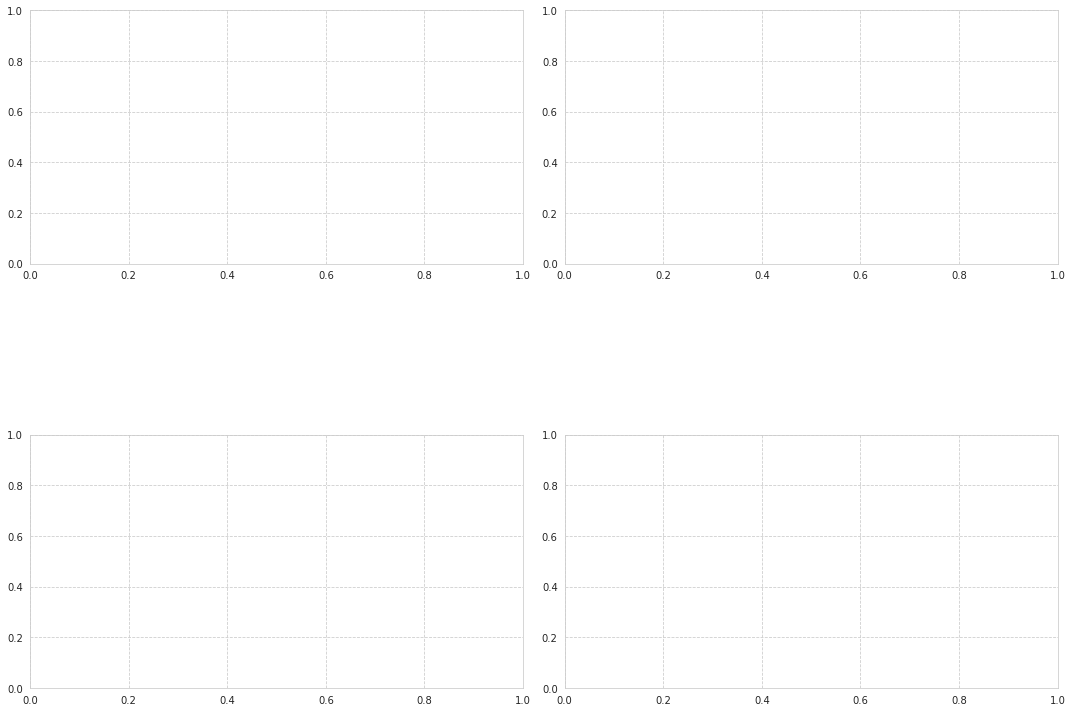

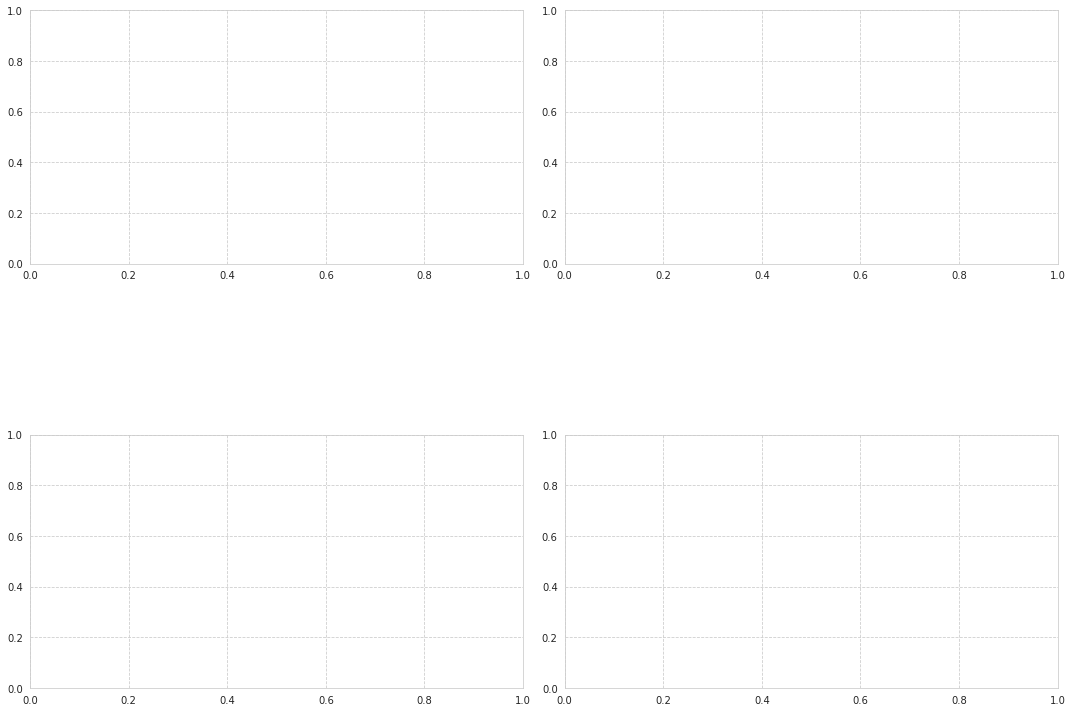

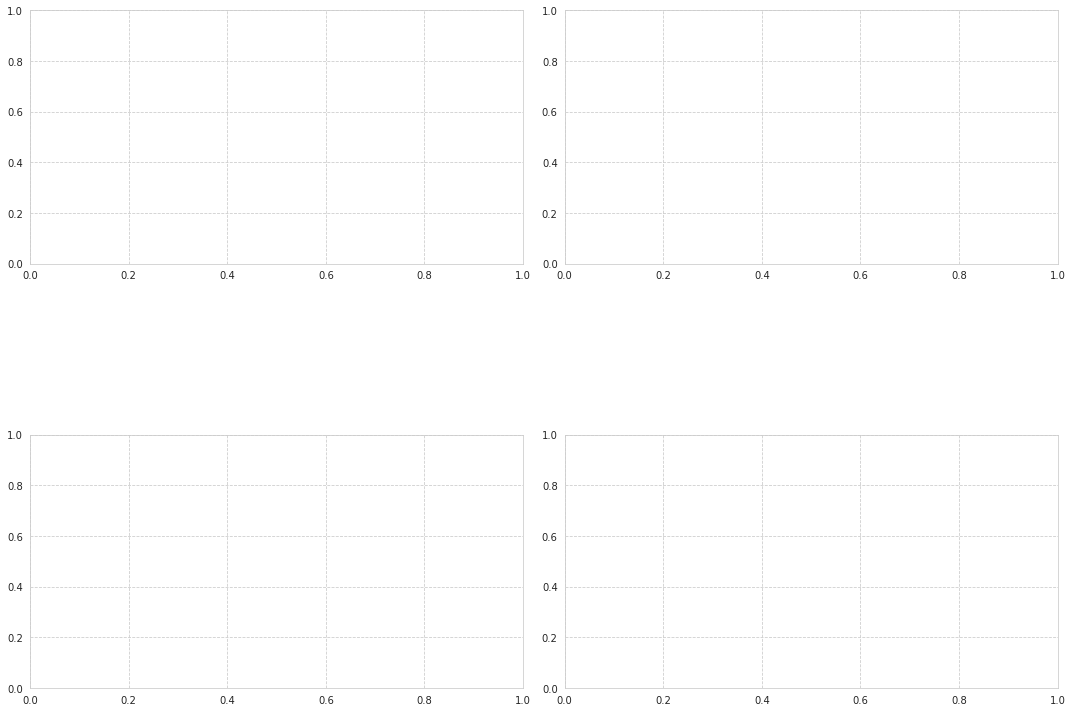

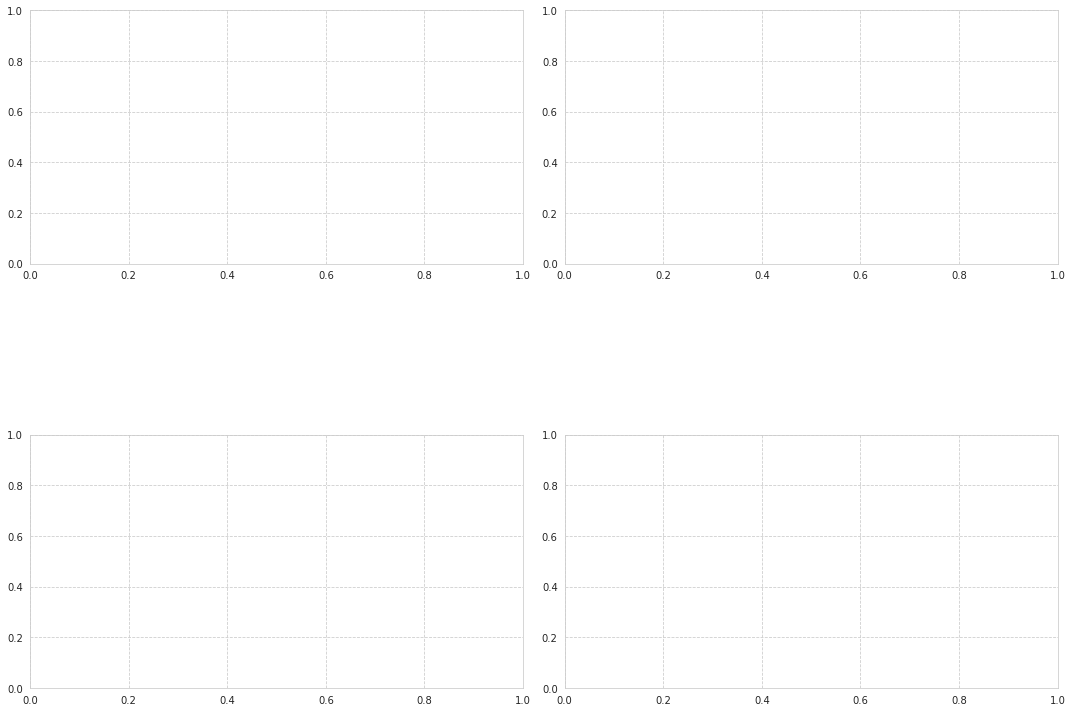

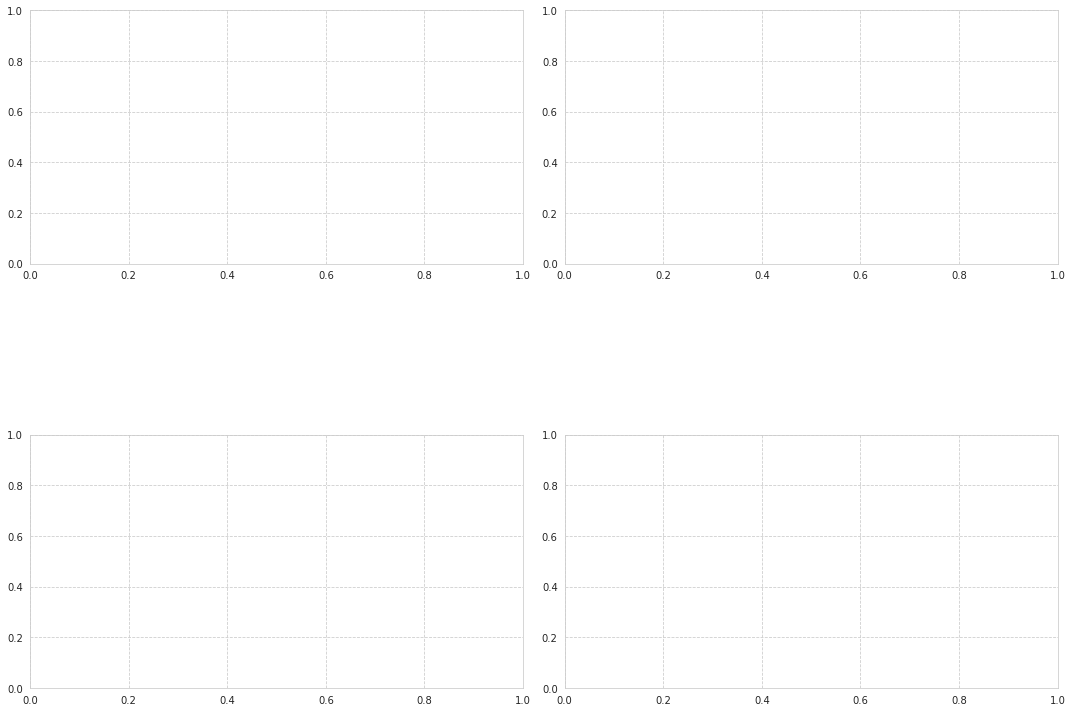

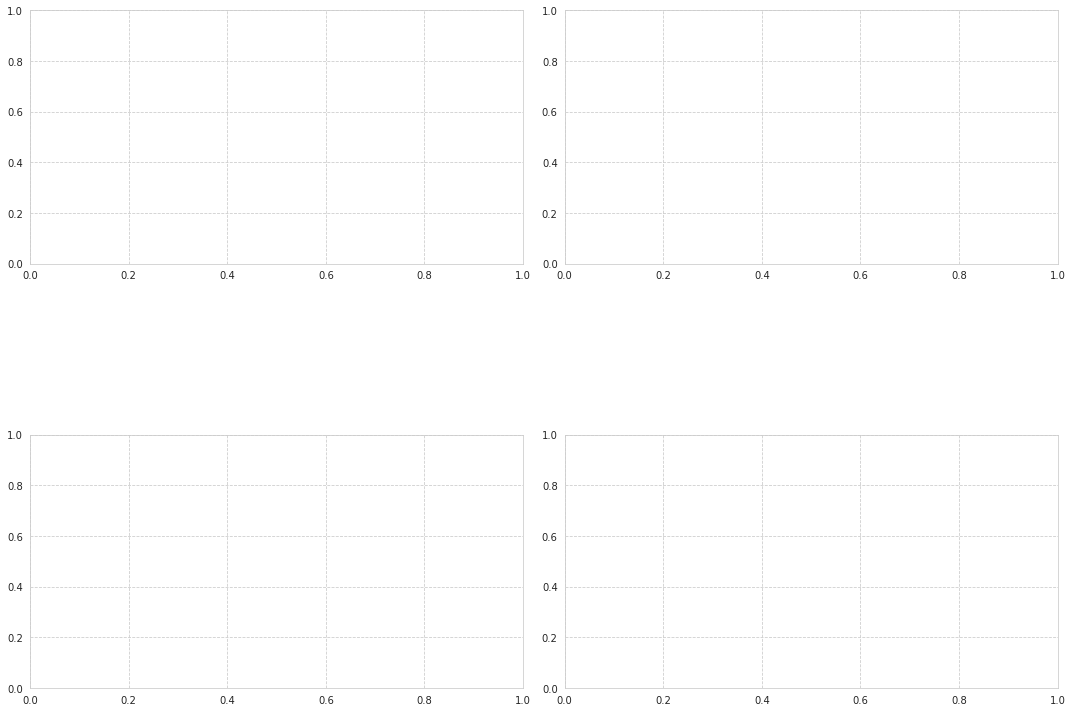

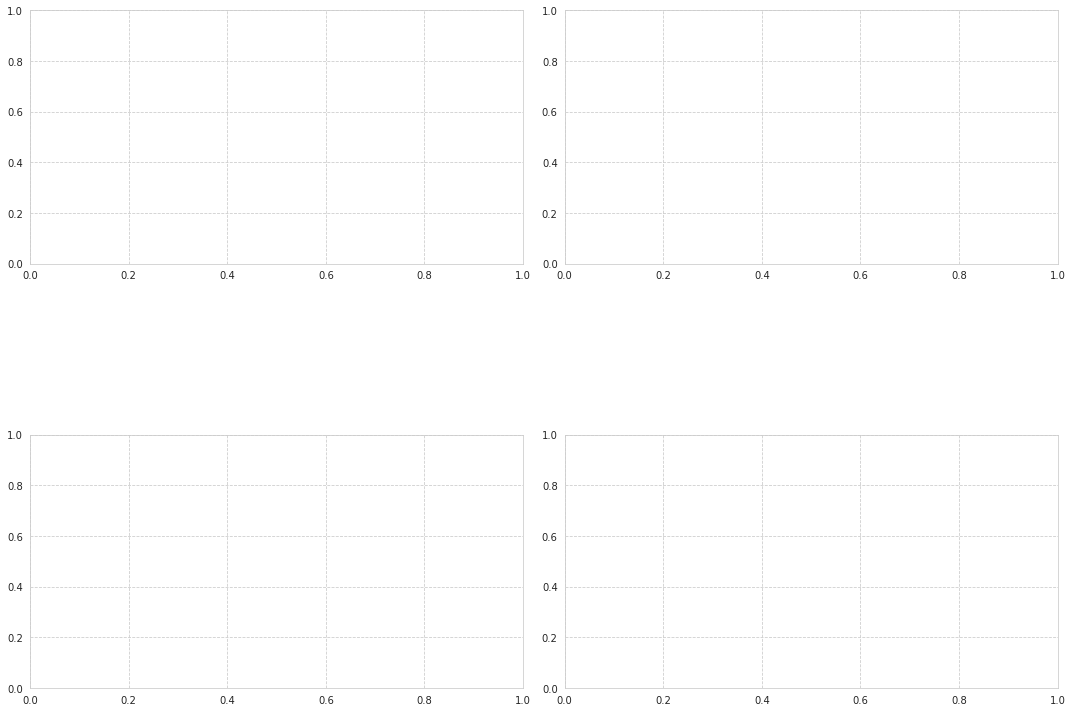

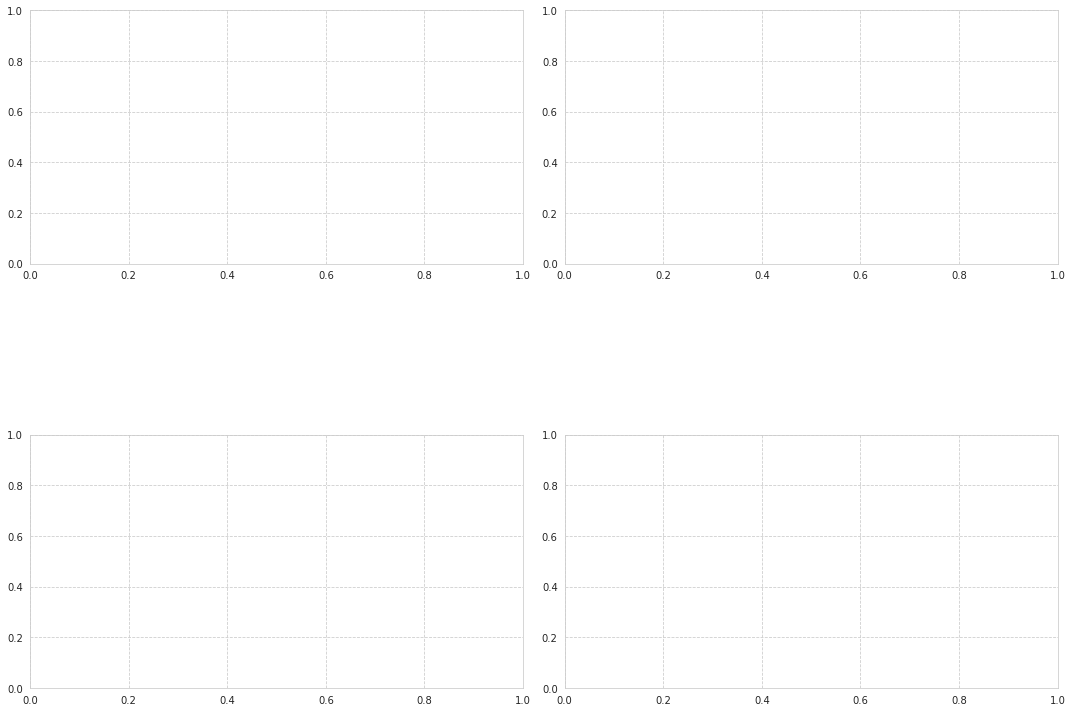

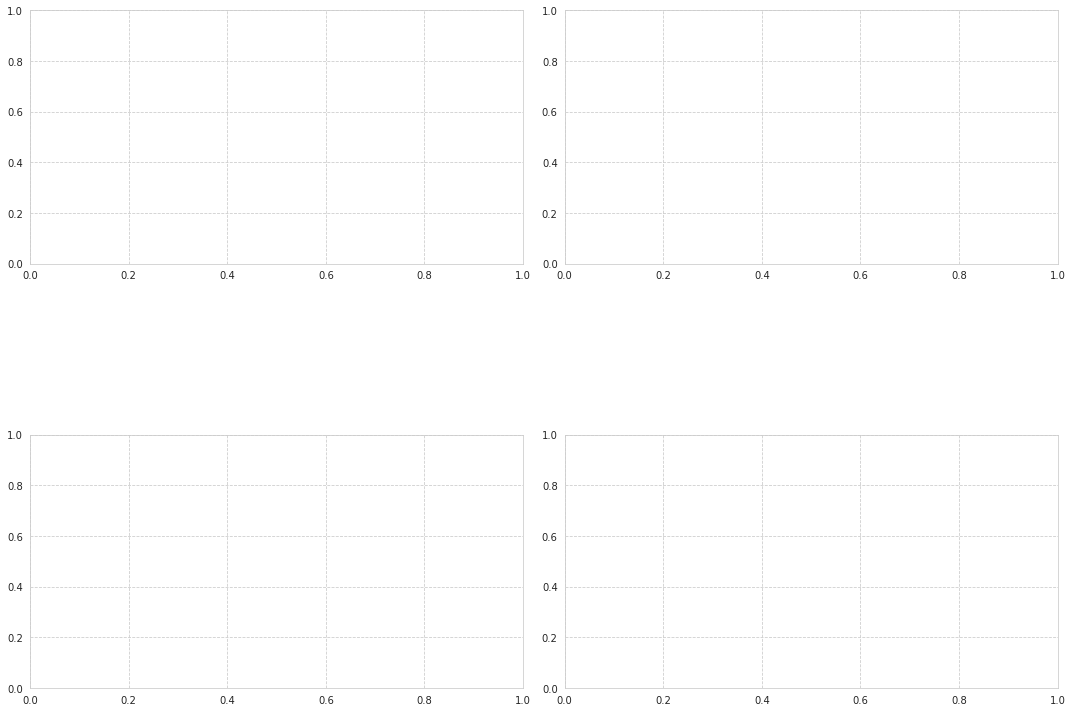

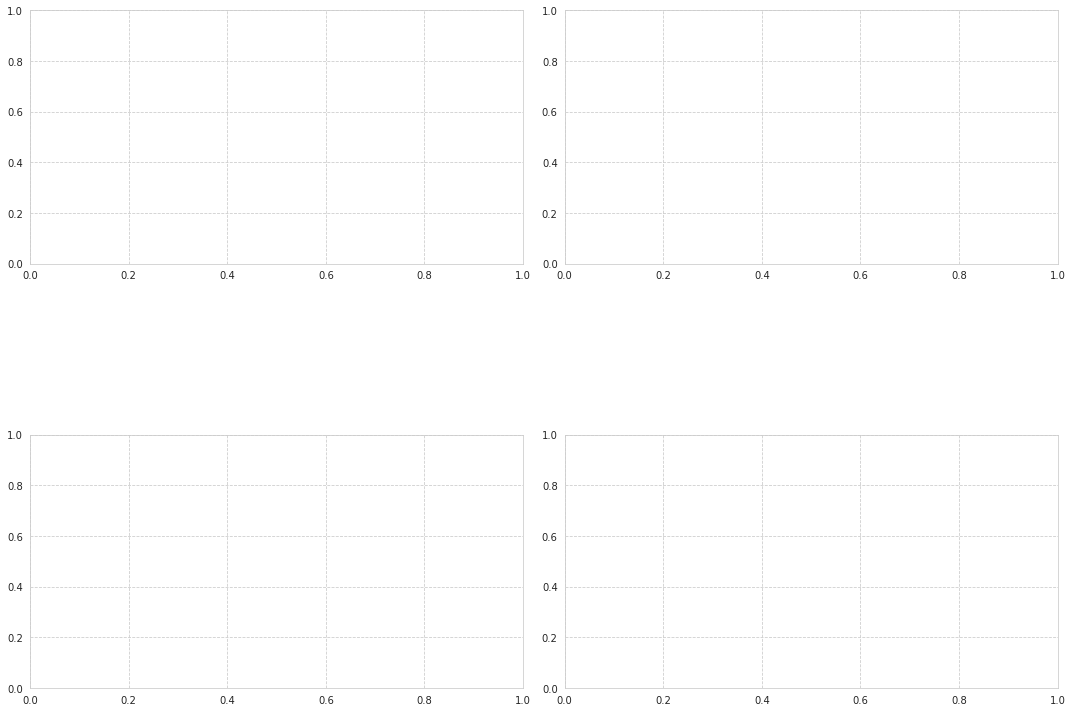

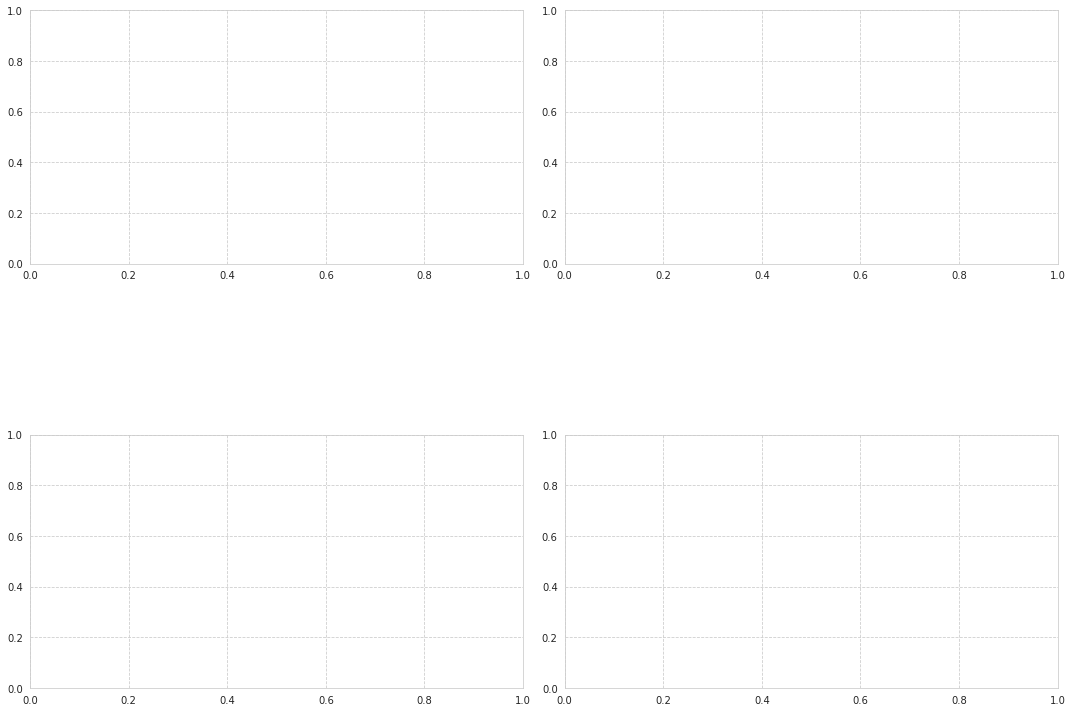

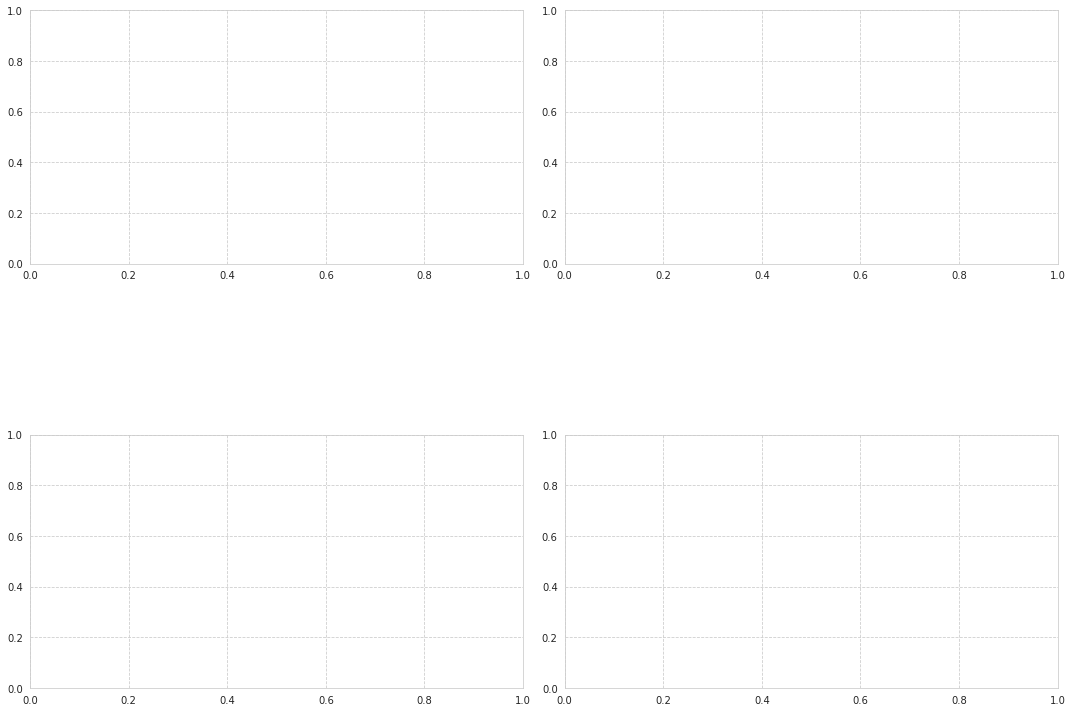

Error in callback <function flush_figures at 0x7fc30dbe8700> (for post_execute):


KeyboardInterrupt: 

In [112]:
# Declaração de constantes e variáveis globais
API_URL = "https://api-cotacao-b3.labdo.it/api/cotacao/cd_acao/"
DIR_IMG = "../img/"
DIR_CSV = "../csv/"

with open('../acoes.txt') as f:
    lines = f.readlines()
    
for acao in lines:

    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
    fig.tight_layout(h_pad = 15.0)        
    
    acao = acao.rstrip('\r\n')
    
    # Invocar a API e retornar os dados da ação solicitada
    response = requests.get("{0}{1}".format(API_URL, acao))

    # Verifica se JSON está vazio, pula para próxima linha se VERDADEIRO
    if len(response.json()) == 0:
        continue
    
    # Montar o dataframe Pandas a partir do JSON
    pregao = pd.DataFrame(response.json())
    pregao["dt_pregao_dt"] = pd.to_datetime(pregao["dt_pregao"], format='%Y%m%d')
    pregao["ano"] = pregao.dt_pregao_dt.dt.year
    pregao["mes"] = pregao.dt_pregao_dt.dt.month
    pregao["dia"] = pregao.dt_pregao_dt.dt.day
    pregao["vl_medio_anterior"] = pregao["vl_medio"].shift(-1)
    pregao["vl_variacao"] = pregao["vl_medio"] - pregao["vl_medio_anterior"]

    # Explorar as colunas do dataframe
    pd.set_option("display.max_columns", None)
    pregao.head()

    # Análise gráfica
    data_inicio = "20200101"
    pregao_plot = pregao.query("dt_pregao >= {0}".format(data_inicio))
    
    if len(pregao_plot) == 0:
        continue;

    if (pregao.dt_pregao_dt.max() != pd.Timestamp(date.today() - timedelta(days = 1))):
        continue;
        
    sns.set_style("whitegrid", {'grid.linestyle': '--'})

    aux = pregao_plot.groupby(by = ['ano', 'mes']).agg({'vl_medio': 'mean'})
    ax = aux.plot.line(ax = axes[0, 0], legend = False)
    ax.set_xticks(range(len(aux)))
    ax.set_xticklabels([item for item in aux.index.tolist()], rotation = 90, ha = 'center');
    ax.set_title("Média Mensal")
    ax.xaxis.grid(True)
    
    ax = pregao_plot.boxplot(column = 'vl_medio', by = ['ano', 'mes'], ax = axes[0, 1]);
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.set_title("Dispersão")

    ax = pregao_plot.groupby(by = ['ano', 'mes']).agg({'vl_medio': iqr}).plot.bar(ax = axes[1, 0], legend = False)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.set_title("Intervalo Interquartil (IIQ)")

    ax = pregao_plot.groupby(by = ['ano', 'mes']).agg({'vl_variacao': sum}).plot.bar(ax = axes[1, 1], legend = False)
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.set_title("Resultado Acumulado Mensal")    
    
    fig.suptitle("{0} - Cotação (R$)".format(acao), fontsize=16);

    pregao.to_csv("{0}{1}.csv".format(DIR_CSV, acao))
        
    fig.savefig("{0}{1}.png".format(DIR_IMG, acao));
    
    plt.close();